# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import plotly.express as px
import matplotlib
from IPython.display import display_html


pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)



In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

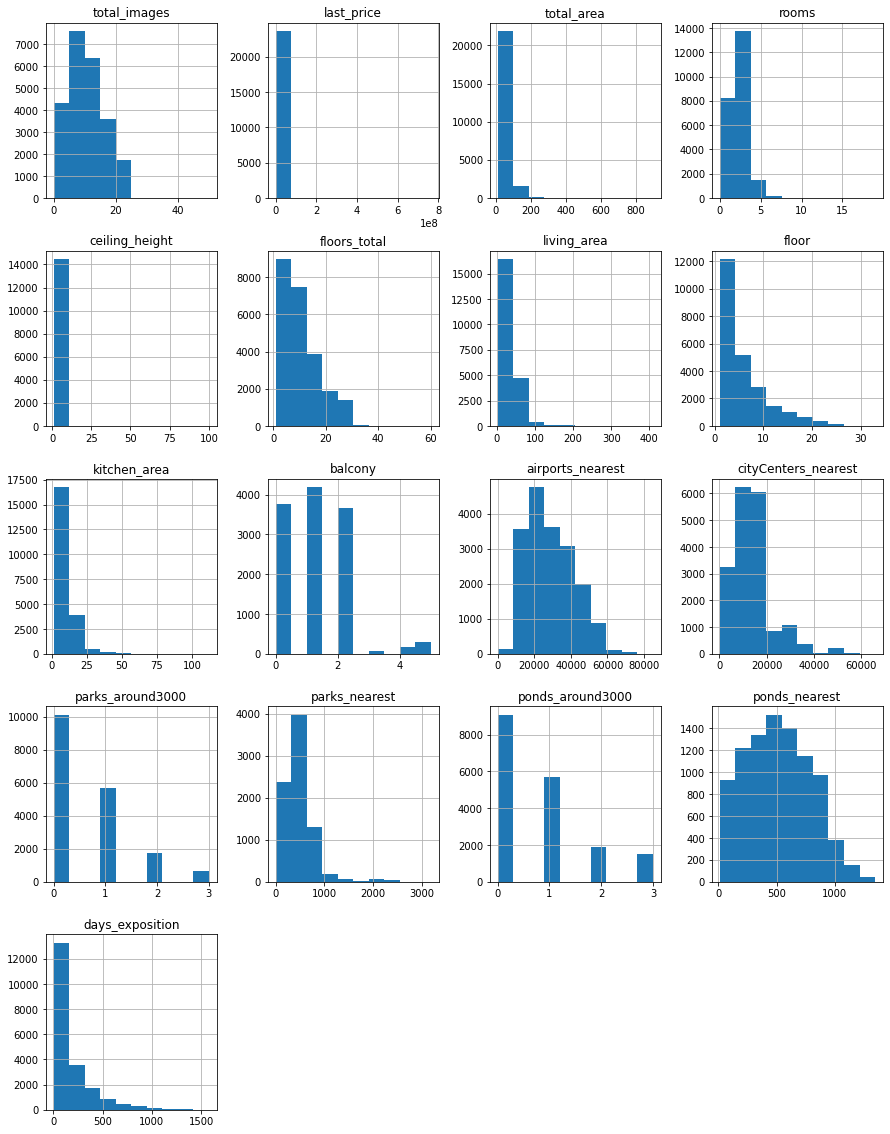

In [3]:
# Построим общую гистограмму для всех столбцов таблицы

df.hist(figsize=(15,20))
plt.show()

In [4]:
df.head()


total_images  last_price  total_area first_day_exposition  rooms  \
0            20 13000000.00      108.00  2019-03-07T00:00:00      3   
1             7  3350000.00       40.40  2018-12-04T00:00:00      1   
2            10  5196000.00       56.00  2015-08-20T00:00:00      2   
3             0 64900000.00      159.00  2015-07-24T00:00:00      3   
4             2 10000000.00      100.00  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70         16.00        51.00      8          NaN   False   
1             NaN         11.00        18.60      1          NaN   False   
2             NaN          5.00        34.30      4          NaN   False   
3             NaN         14.00          NaN      9          NaN   False   
4            3.03         14.00        32.00     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False         25.00      NaN  Санкт-Петербург          18863.00   
1      False         11.00     2.00   посёлок Шушары          12817.00   
2      False          8.30     0.00  Санкт-Петербург          21741.00   
3      False           NaN     0.00  Санкт-Петербург          28098.00   
4      False         41.00      NaN  Санкт-Петербург          31856.00   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.00              1.00         482.00              2.00   
1             18603.00              0.00            NaN              0.00   
2             13933.00              1.00          90.00              2.00   
3              6800.00              2.00          84.00              3.00   
4              8098.00              2.00         112.00              1.00   

   ponds_nearest  days_exposition  
0         755.00              NaN  
1            NaN            81.00  
2         574.00           558.00  
3         234.00           424.00  
4          48.00           121.00

In [5]:
# посмотрим типы данных и кол-во ненулевых значений

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Вывод
Всего у нас 23699 записи. Для целого ряда столбцов есть пропущенные значения и некорректный тип данных. По ряду признаков есть аномальные значения.

### Предобработка данных

#### Изучим пропущенные значения в столбцах

В дате размещения объявления сохранено время, к тому же сам формат даты не удобен для чтения. Поэтому
 оставим только дату, без часов, и заменим тип данных на временной.

У почти половины объектов нет информации о высоте потолка, а у некоторых объектов она равна 1.75 или даже 100. Судя по всему не все пользователи считают эту информацию важной и не указывают ее. 
Посмотрим, сколько квартир имеют некорректную информацию об этом параметре. Будем считать достоверной высоту потолка от 2.3 до 6 метров.

Данных о высоте потолка нет у 9195 квартир
Данные не вызывают доверия у 45 квартир, встречаются такие значения:
25.0 2.0 32.0 8.0 27.0 24.0 26.0 1.2 8.3 2.2 14.0 1.75 20.0 2.25 22.6 27.5 10.3 1.0 100.0


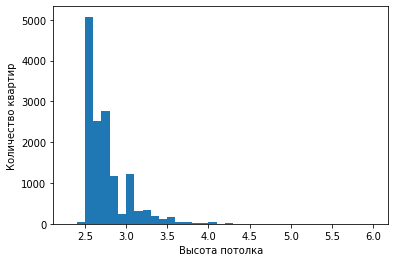

In [6]:
# считаем NaNы 
print(f'Данных о высоте потолка нет у {df.ceiling_height.isna().sum()} квартир')

# считаем квартиры с недостоверной высотой
print(f'Данные не вызывают доверия у {len(df.query("ceiling_height < 2.3 or ceiling_height > 6"))} квартир, встречаются такие значения:')
print(*df.query("ceiling_height < 2.3 or ceiling_height > 6")['ceiling_height'].unique())

# посмотрим, как распределяются "достоверные" высоты
plt.hist(df[df['ceiling_height'].notna()].ceiling_height, bins=37, range=(2.3, 6))
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')
plt.show()

In [7]:
# Посмотрим в каких стобцах есть пропуски
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
# квартиры с неуказанной жилой площадью, но не студии
len(df[(df['living_area'].isna()) & (df['studio'] == False)]) 


1893

In [9]:
# квартиры с неуказанной площадью кухни, но не студии
len(df[(df['kitchen_area'].isna()) & (df['studio'] == False)]) 


2129

In [10]:
# Удаляем записи, где отсутствует локация и этажность
df.dropna(subset=['locality_name'], inplace=True)
df.dropna(subset=['floors_total'], inplace=True)



In [11]:
# квартиры с неуказанной жилой площадью, но не свободной планировки
len(df[(df['living_area'].isna()) & (df['open_plan'] == False)])


1860

In [12]:
# посмотрим какая площадь кухни указана в студиях
df[df['studio'] == True]['kitchen_area'].unique() 


array([nan])

In [13]:
# есть ли квартиры с суммой жилой и кухонных площадей больше общей?
area_check = df.total_area - df.kitchen_area - df.living_area 
df[area_check <= 0][['total_area', 'kitchen_area', 'living_area']]


total_area  kitchen_area  living_area
184         30.20          6.20        26.10
220         37.00          9.00        28.00
545         23.80          5.00        20.00
551         31.59          9.28        30.55
601         53.70          7.00        48.30
...           ...           ...          ...
22869       25.00         11.00        14.00
22963      102.00         24.00        78.00
23202       67.92         13.04        63.00
23297       48.20          6.00        42.20
23680       59.00          7.00        52.00

[132 rows x 3 columns]

In [14]:
print(len(df.query('rooms == 0'))) # всего квартир с нулем комнат
print(len(df.query('rooms == 0 and studio == False and open_plan == True'))) # из них не студии, но со свободной планировкой
print(len(df.query('rooms == 0 and studio == True'))) # или студии
# а кто-то считает, что в студии не ноль комнат, а одна. это мы в дальнецшем исправим
print(df.query('rooms != 0 and studio == True')['rooms'].unique()) 



194
59
135
[1]


 Большинство квартир с потерянными жилой площадью и площадью кухни - не студии и не свободной планировки, видимо, их владельцы поленились указать информацию.
 
 На будущее следует  выстроить систему проверки наличия этих чисел при получении данных от пользователя. К сожалению, достоверного способа заполнить пропуски, не имея в наличии документации о здании очень сложно.
 
 В рамках учебного проекта было принято решение:
для студий площадь кухни назначим 0,  для остальных квартир площадь кухни, и жилую площадь посчитаем как долю от общей площади. Величину доли посчитаем медианную для квартир с аналогичным количеством комнат.


Помимо этого обнаружилось 132 квартиры с общей площадью меньшей или равной сумме жилой и кухни. Для подобных квартир возьмем за основу эмпирическое правило - жилая площадь = 80% общей за вычетом кухни.


Поле "является ли апартаментами" заполнено только у 12% квартир. Скорее всего, если поле не заполнено, то и квартира апартаментами не является. Заменим отсутствующие значения на False, и, yбедимся, что тип данных столбца булев.

У объектов без указания балкона заменим отсутствующие значения на 0.Кроме того, заменим тип данных в столбце на целочисленный. 

У 49 объектов не указано название города. Так как этy информацию невозможно восстановить, удалим эти строки. В дальнейшем надо предпринять шаги по контролю ввода пользователем этих данных. 

Пропуски в столбце days_exposition оставим без изменения - возможно, квартиры были сняты с продажи по каким-то причинам.

В столбцах parks_around3000, parks_nearest, ponds_around3000, ponds_nearest пропущено до 65% данных. Эти пропуски оставим без изменений - без точного адреса их не восстановить.

В столбце "количество комнат" встречаются нули. Подобные объекты или студии, или имеют свободную планировку. Но при этом некоторые пользователи называют студии однокомнатными. Это не правильно, всем студиям укажем количество комнат 0. 



##### План работы 



 Мы проанализировали в первом приближении все пропущенные или очевидно некорректные значения, и составили план действий:

-заменить пропущенные значения высоты потолка на медианные, а где возможно - переместить ошибочную запятую

-высчитать жилые площади и площади кухонь на основе замеченных закономерностей

-заполнить пропущенные значения в полях "апартаменты" и "балкон"

-квартирам-студям назначить число комнат 0

-переписать цены квартир в тысячах рублей

-привести даты размещения объявлений к временному типу данных и отбросить часы

-заполнить пропущенные высоты зданий

-изменить типы данных


В таблице есть пропуски в автоматически полученных данных - о расположении объекта относительно парков и водоемов, возможно, из-за некорректно заполненного адреса. 
В будущем следует требовательнне относиться к заполнению пользователем точного адреса объекта - он позволяет выяснить много важной информации о квартире.











##### Столбец ceiling_height


In [15]:
# поделим на 10 высоты от 22 до 32
df.loc[(df['ceiling_height'] >= 22) & (df['ceiling_height'] <= 32), 'ceiling_height'] = df['ceiling_height'] / 10

# Заменяем высотy потолков на медианное значение по всему датасету
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median()) 
df['ceiling_height'].describe() # посмотрим, что получилось


count   23565.00
mean        2.70
std         0.69
min         1.00
25%         2.60
50%         2.65
75%         2.70
max       100.00
Name: ceiling_height, dtype: float64

##### Столбец last_price


In [16]:
df['last_price'] = df['last_price'] / 1000 # отбросим три нуля
df.head() # проверим, что получилось

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000.00      108.00  2019-03-07T00:00:00      3   
1             7     3350.00       40.40  2018-12-04T00:00:00      1   
2            10     5196.00       56.00  2015-08-20T00:00:00      2   
3             0    64900.00      159.00  2015-07-24T00:00:00      3   
4             2    10000.00      100.00  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70         16.00        51.00      8          NaN   False   
1            2.65         11.00        18.60      1          NaN   False   
2            2.65          5.00        34.30      4          NaN   False   
3            2.65         14.00          NaN      9          NaN   False   
4            3.03         14.00        32.00     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False         25.00      NaN  Санкт-Петербург          18863.00   
1      False         11.00     2.00   посёлок Шушары          12817.00   
2      False          8.30     0.00  Санкт-Петербург          21741.00   
3      False           NaN     0.00  Санкт-Петербург          28098.00   
4      False         41.00      NaN  Санкт-Петербург          31856.00   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.00              1.00         482.00              2.00   
1             18603.00              0.00            NaN              0.00   
2             13933.00              1.00          90.00              2.00   
3              6800.00              2.00          84.00              3.00   
4              8098.00              2.00         112.00              1.00   

   ponds_nearest  days_exposition  
0         755.00              NaN  
1            NaN            81.00  
2         574.00           558.00  
3         234.00           424.00  
4          48.00           121.00

##### Столбцы living_area и  kitchen_area


In [17]:
# Заменяем пустые значения жилой площади и площади кухни
living_ratio = df['living_area'].mean() / df['total_area'].mean()
df['living_area'].fillna(living_ratio * df['total_area'], inplace=True)

kitchen_ratio = df['kitchen_area'].mean() / df['total_area'].mean()
df['kitchen_area'].fillna(kitchen_ratio * df['total_area'], inplace=True)

# в квартирах-студиях кухонь нет - назначаем ноль
df.loc[df['studio'] == True, 'kitchen_area'] = 0 

In [18]:
# проверим, что получилось 
df['living_area'].describe() 


count   23565.00
mean       34.59
std        22.37
min         2.00
25%        19.00
50%        30.00
75%        42.10
max       409.70
Name: living_area, dtype: float64

In [19]:
df['kitchen_area'].describe() 

count   23565.00
mean       10.47
std         6.08
min         0.00
25%         7.00
50%         9.00
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

In [20]:
# проверим еще раз есть ли квартиры с суммой жилой и кухонных площадей больше общей

df[df['living_area'] > df['total_area']]['rooms'].count() 

0

##### Столбцы is_apartment и balcony


In [21]:
df['is_apartment'] = df['is_apartment'].fillna(value=False) # нет информации - не апартаменты
df['balcony'] = df['balcony'].fillna(value=0) # нет информации - нет балкона

In [22]:
# Посмотрим уникальные значения для parks_around3000 и приравняем Nan к 0
df['parks_around3000'].unique()
df['parks_around3000'] = df['parks_around3000'].fillna(0)

##### Столбец floors_total


In [23]:
# заполним пропуски в общем количестве этажей 
for i in [5, 9, 16, 24]:
    df.loc[(df['floors_total'].isna()) & (df['floor'] <= i), 'floors_total'] = i
    
df.floors_total.describe() # проверим, что получилось


count   23565.00
mean       10.68
std         6.59
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

##### Столбец rooms


In [24]:
print(len(df.query('rooms == 0'))) # всего квартир с нулем комнат
print(len(df.query('rooms == 0 and studio == False and open_plan == True'))) # из которых не студии, но со свободной планировкой


print(len(df.query('rooms == 0 and studio == True'))) # или студии

print(df.query('rooms != 0 and studio == True')['rooms'].unique()) 

# в квартирах-студиях нет комнат  - назначаем ноль
df.loc[df['studio'] == True, 'rooms'] = 0 

df.rooms.describe() # проверим, что получилось



194
59
135
[1]


count   23565.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

In [1]:
df['rooms'][df['rooms']==0].count()
# Имеем 194 случаев с нулевым количеством комнат,
# исходя из общей и жилой площади это маленькие однокомнатные квартиры

# исправим ошибку заполнения, прописав количетво комнат 1
df.loc[df['rooms']==0, 'rooms'] = 1


NameError: name 'df' is not defined

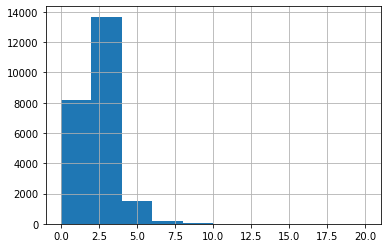

In [26]:
# По комнатам вполне может быть, оставляем как есть
df['rooms'].hist(range=(0,20))
plt.show()
df['rooms'].describe()

# посмотрим на рекомендации по выбросам по комнатам
box = px.box(df,x=['rooms'])
#,range_x=[0,10]
box.show()
#В данном случае выброс по комнатам не является критичным. Оставляем как есть

##### Столбец locality_name


In [27]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [28]:
def category_locality_name(row):
    if 'Янино-1' in row:
        return 'городской посёлок Янино-1'
    elif 'Мурино' in row:
        return 'посёлок Мурино'
    elif 'Кудрово' in row:
        return 'деревня Кудрово'
    elif 'Красный Бор' in row:
        return 'посёлок городского типа Красный Бор'
    elif 'Фёдоровское' in row:
        return 'Фёдоровское'
    elif 'Лебяжье' in row:
        return 'посёлок городского типа Лебяжье'
    elif 'Кузьмоловский' in row:
        return 'посёлок городского типа Кузьмоловский'
    elif 'Аннино' in row:
        return 'посёлок Аннино'
    elif 'Новый Свет' in row:
        return 'посёлок Новый Свет'
    elif 'Никольское' in row:
        return 'село Никольское'
    elif 'Бугры' in row:
        return 'посёлок Бугры'
    elif 'Рощино' in row:
        return 'посёлок городского типа Рощино'
    elif 'Лесогорский' in row:
        return 'поселок городского типа Лесогорский'
    elif 'Петровское' in row:
        return 'посёлок Петровское'
    elif 'Щеглово' in row:
        return 'посёлок Щеглово'
    elif 'Мичуринское' in row:
        return 'посёлок Мичуринское'
    elif 'Вещево' in row:
        return 'посёлок при железнодорожной станции Вещево'
    elif 'Токсово' in row:
        return 'посёлок городского типа Токсово'
    elif 'Старая Малукса' in row:
        return 'посёлок Старая Малукса'
    elif 'Калитино' in row:
        return 'поселок Калитино'
    elif 'Приладожский' in row:
        return 'поселок городского типа Приладожский'
    elif 'Пансионат Зелёный Бор' in row:
        return 'посёлок Пансионат Зелёный Бор'
    elif 'Рабитицы' in row:
        return 'поселок Рабитицы'
    elif 'Лесное' in row:
        return 'поселок Лесное'
    elif 'Павлово' in row:
        return 'село Павлово'
    elif 'Победа' in row:
        return 'Победа'
    elif 'Терволово' in row:
        return 'Терволово'
    elif 'Советский' in row:
        return 'Советский'
    elif 'Вырица' in row:
        return 'Вырица'
    elif 'Тельмана' in row:
        return 'Тельмана'
    elif 'Большая Ижора' in row:
        return 'Большая Ижора'
    elif 'Рахья' in row:
        return 'Рахья'
    elif 'Зимитицы' in row:
        return 'Зимитицы'
    elif 'Свердлова' in row:
        return 'Свердлова'
    elif 'Рябово' in row:
        return 'Рябово'
    elif 'Поляны' in row:
        return 'Поляны'
    elif 'Мга' in row:
        return 'Мга'
    elif 'Ильичёво' in row:
        return 'Ильичёво'
    elif 'Гаврилово' in row:
        return 'Гаврилово'
    elif 'Назия' in row:
        return 'Назия'
    elif 'Гарболово' in row:
        return 'Гарболово'
    elif 'Приветнинское' in row:
        return 'Приветнинское'
    elif 'Мельниково' in row:
        return 'Мельниково'
    elif 'Усть-Луга' in row:
        return 'Усть-Луга'
    elif 'Любань' in row:
        return 'Любань'
    elif 'Стеклянный' in row:
        return 'Стеклянный'
    elif 'Форносово' in row:
        return 'Форносово'
    elif 'Сумино' in row:
        return 'Сумино'
    elif 'Возрождение' in row:
        return 'Возрождение'
    elif 'Лисий Нос' in row:
        return 'Лисий Нос'
    elif 'Жилгородок' in row:
        return 'Жилгородок'
    elif 'Громово' in row:
        return 'Громово'
    elif 'Коробицыно' in row:
        return 'Коробицыно'
    elif 'Кобралово' in row:
        return 'Кобралово'
    elif 'Перово' in row:
        return 'Перово'
    else:
        return row
    
    

In [29]:
# Oтразим обновленные локации без повторов в новом поле
df['locality_name_no_duplicates'] = df['locality_name'].apply(category_locality_name)

# если город не указан- удаляем его
df.dropna(subset=['locality_name'], inplace=True) 

# Проверим сокращение уникальных значений
print('До', len(df['locality_name'].unique()))
print('После', len(df['locality_name_no_duplicates'].unique()))

До 364
После 305


#### Изменим типы данных

In [30]:
# Приводим в целочисленный тип стоимость квартиры
df['last_price'] = df['last_price'].astype(int)

# Приводим этажность к целочисленному типу
df['floors_total'] = df['floors_total'].astype(int)

# Приводим к типу даты дату публикации, и переведем в формат без времени, т.к. время не указано
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT')
df['first_day_exposition'] = df['first_day_exposition'].dt.round('1d') # отбросим время

# Выясняем количество значений в аппартаментах. Всего аппартаменты - 50. Заменяем пропущенные значения на False
df['is_apartment'] = df['is_apartment'].fillna(value=False)

# Приводим в целочисленный тип количество балконов. Заменяем пропущенные значения на 0
df['balcony'].value_counts()
df['balcony'] = df['balcony'].astype(int)

# Приводим в целочисленный тип количество парков. Заменяем пропущенные значения на 0
df['parks_around3000'] = df['parks_around3000'].fillna(value=0).astype(int)

# Приводим в целочисленный тип количество прудов. Заменяем пропущенные значения на 0
df['ponds_around3000'] = df['ponds_around3000'].fillna(value=0).astype(int)




#### Редкие и выбивающиеся значения



Редкими можно назвать значения где:

-высота потолка 100 м.

-стоимость квадратного метра более 270 тыс.


Также можно заметить, что жилых зданий в Ленобласти выше 35 этажей не существует. Возможно, у этих объектов город указан ошибочно. Так как эти объекты добавляют шума в данные, от них следует избавиться.

После этого заменим выбивающиеся высоты потолков на медианные, а также избавимся от квартир, чья площадь превышает 99% перцентиль для такой комнатности.

In [31]:
# Добавляем столбцы дня недели, месяца и года

df['weekday'] = df['first_day_exposition'].dt.weekday 
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23565, dtype: datetime64[ns]

In [32]:
df['first_day_exposition'].astype(int)
df['weekday'].astype(int)

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23565, dtype: int64

In [33]:
# Добавляем столбец со стоимостью квадратного метра (per_meter_price) - отношение цены объекта к его площади 
#и приводим его в целочисленный тип

df['per_meter_price'] = df['last_price']/df['total_area']
df['per_meter_price'] = df['per_meter_price'].astype(int)


#создадим новый датайфрейм и возьмем только верные данные, он понадобится нам попозже

df_good = df.loc[(df['per_meter_price'] < 270) & (df['ceiling_height'] != 100) & (df['floors_total']  < 36)]

# оставим квартиры с таким количеством комнат, которое встречается больше 1 раза. 

room_info = pd.DataFrame(zip(df.groupby('rooms')['total_area'].quantile(q=0.95), df.groupby('rooms')['rooms'].count()))
room_info = room_info.rename(columns={0:'95%', 1:'count'})

room_info = room_info[room_info['count'] > 1]
df_good = df_good.loc[df['rooms'].isin(room_info.index)]


# заменим площади квартир в верхних 5% на нули и удалим их
for i, row in room_info.iterrows():
    df_good.loc[(df_good['rooms'] == i) & (df_good['total_area'] > row[1]), 'total_area'] = 0
df_good = df_good.loc[df_good['total_area'] != 0]
df_good = df_good.reset_index(drop=True)

# посмотрим, что получилось
df_good.describe(percentiles=[0.05, 1/2, 0.95, 0.99])

total_images  last_price  total_area    rooms  ceiling_height  \
count      22895.00    22895.00    22895.00 22895.00        22895.00   
mean           9.84     5624.81       56.85     2.00            2.69   
std            5.65     4076.43       24.94     0.91            0.26   
min            0.00       12.00       12.00     1.00            1.00   
5%             1.00     1850.00       31.00     1.00            2.50   
50%            9.00     4550.00       51.00     2.00            2.65   
95%           20.00    12952.70      102.30     4.00            3.07   
99%           20.00    22746.42      146.80     4.00            3.50   
max           50.00    84382.00      494.10     5.00           20.00   

       floors_total  living_area    floor  kitchen_area  balcony  \
count      22895.00     22895.00 22895.00      22895.00 22895.00   
mean          10.77        32.42     5.91         10.11     0.60   
std            6.60        15.89     4.90          5.16     0.96   
min            1.00         2.00     1.00          0.00     0.00   
5%             4.00        15.20     1.00          5.30     0.00   
50%            9.00        30.00     4.00          9.00     0.00   
95%           25.00        61.10    16.00         18.50     2.00   
99%           26.00        84.52    23.00         30.65     5.00   
max           35.00       282.22    33.00        100.70     5.00   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count          17397.00             17418.00          22895.00        7570.00   
mean           28902.98             14482.59              0.45         495.18   
std            12779.54              8546.21              0.73         343.29   
min                0.00               208.00              0.00           1.00   
5%             11518.00              3871.85              0.00          96.00   
50%            27038.00             13263.50              0.00         458.00   
95%            51425.00             31863.15              2.00         980.00   
99%            58916.00             50125.00              3.00        2102.00   
max            84869.00             65968.00              3.00        3190.00   

       ponds_around3000  ponds_nearest  days_exposition  weekday    month  \
count          22895.00        8578.00         19895.00 22895.00 22895.00   
mean               0.57         523.61           177.96     2.57     6.41   
std                0.86         277.79           216.60     1.79     3.49   
min                0.00          13.00             1.00     0.00     1.00   
5%                 0.00          96.00             9.00     0.00     1.00   
50%                0.00         507.00            94.00     3.00     6.00   
95%                3.00         981.00           631.00     6.00    12.00   
99%                3.00        1159.00          1057.06     6.00    12.00   
max                3.00        1344.00          1580.00     6.00    12.00   

          year  per_meter_price  
count 22895.00         22895.00  
mean   2017.38            95.59  
std       1.03            34.23  
min    2014.00             0.00  
5%     2015.00            40.00  
50%    2017.00            94.00  
95%    2019.00           153.00  
99%    2019.00           204.06  
max    2019.00           269.00

Таким образом, мы избавились от около 5% объектов, снизили максимальную площадь до 517 кв.м., а стоимость квадратного метра менее 269 тыс., и практически не затронули остальные параметры.

In [34]:
# проведем итоговую проверку на дубликаты
df_good.shape

(22895, 27)

In [35]:
print('Количество явных дубликатов', df_good.duplicated().sum())

Количество явных дубликатов 0


In [36]:
# Проверяем количество пропущенных значений
df_good.isnull().sum()

total_images                       0
last_price                         0
total_area                         0
first_day_exposition               0
rooms                              0
ceiling_height                     0
floors_total                       0
living_area                        0
floor                              0
is_apartment                       0
studio                             0
open_plan                          0
kitchen_area                       0
balcony                            0
locality_name                      0
airports_nearest                5498
cityCenters_nearest             5477
parks_around3000                   0
parks_nearest                  15325
ponds_around3000                   0
ponds_nearest                  14317
days_exposition                 3000
locality_name_no_duplicates        0
weekday                            0
month                              0
year                               0
per_meter_price                    0
d

#### Выводы
 Выполнена первая предобработка данных. 
 
 
Tеперь цены квартир отображаются в тысячах рублей, лишние нули не мешаются 

в поле "дата размещения" осталась только дата, без времени

добавлены столбцы - день недели, месяц и год публикации объявления

высоты потолков приведены к реалистичным

пропущенные этажности зданий заполнены

пропуски в жилых площадях и площадях кухнь заполнены

пропущенные значения в полях "апартаменты" и "балкон" заполнены. 

после заполнения пропусков тип данных в столбце "апартаменты" булев, как и должно быть

квартирам-студям назначено число комнат 0

рассчитаны и добавлены параметры цены квадратного метра

данные приведены к целочисленным, где это возможно

количество объектов уменьшилось до 22294


Пропуски в автоматически собранных данных могли появиться вследствие неполной или некорректной информации от пользователя, например, адресе квартиры. 

Пропуски и ошибки в информации, переданной непосредственно пользователями - вероятно, опечатки.
Возможно, следует доработать форму подачи объявлений и дополнить ее контролем вводимых данных.

### Посчитайте и добавьте в таблицу новые столбцы

Для более глубокого анализа данных рассчитаем следующие параметры:



-тип этажа - первый, последний, другой


-соотношение жилой и общей площадей

-отношение площади кухни к общей

In [37]:
 # проверим, что получилось 
display(df_good.head())


total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000      108.00           2019-03-07      3   
1             7        3350       40.40           2018-12-04      1   
2            10        5196       56.00           2015-08-20      2   
3             2       10000      100.00           2018-06-19      2   
4            10        2890       30.40           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16        51.00      8         False   False   
1            2.65            11        18.60      1         False   False   
2            2.65             5        34.30      4         False   False   
3            3.03            14        32.00     13         False   False   
4            2.65            12        14.40      5         False   False   

   open_plan  kitchen_area  balcony              locality_name  \
0      False         25.00        0            Санкт-Петербург   
1      False         11.00        2             посёлок Шушары   
2      False          8.30        0            Санкт-Петербург   
3      False         41.00        0            Санкт-Петербург   
4      False          9.10        0  городской посёлок Янино-1   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0          18863.00             16028.00                 1         482.00   
1          12817.00             18603.00                 0            NaN   
2          21741.00             13933.00                 1          90.00   
3          31856.00              8098.00                 2         112.00   
4               NaN                  NaN                 0            NaN   

   ponds_around3000  ponds_nearest  days_exposition  \
0                 2         755.00              NaN   
1                 0            NaN            81.00   
2                 2         574.00           558.00   
3                 1          48.00           121.00   
4                 0            NaN            55.00   

  locality_name_no_duplicates  weekday  month  year  per_meter_price  
0             Санкт-Петербург        3      3  2019              120  
1              посёлок Шушары        1     12  2018               82  
2             Санкт-Петербург        3      8  2015               92  
3             Санкт-Петербург        1      6  2018              100  
4   городской посёлок Янино-1        0      9  2018               95

In [38]:
# Добавляем столбец с отношением жилой площади к общей (area_ratio)
df_good['living_area_ratio'] = df_good['living_area'] / df_good['total_area']
                                                 
                                                 
# Добавляем столбец с отношением площади кухни к общей                                              
df_good['kitchen_area_ratio'] = df_good['kitchen_area'] / df_good['total_area']



In [39]:
# Создаём функцию для заполнения нового столбца с типом этажа
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df_good['floor_type'] = df_good.apply(floor_group, axis=1)



In [40]:
# расстояние до центра города в километрах
df_good['city_center1000'] = round(df_good['cityCenters_nearest'] / 1000, 0)


In [41]:
# посмотрим, что получилось
display(df_good.head())

df_good.describe()  


total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000      108.00           2019-03-07      3   
1             7        3350       40.40           2018-12-04      1   
2            10        5196       56.00           2015-08-20      2   
3             2       10000      100.00           2018-06-19      2   
4            10        2890       30.40           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16        51.00      8         False   False   
1            2.65            11        18.60      1         False   False   
2            2.65             5        34.30      4         False   False   
3            3.03            14        32.00     13         False   False   
4            2.65            12        14.40      5         False   False   

   open_plan  kitchen_area  balcony              locality_name  ...  \
0      False         25.00        0            Санкт-Петербург  ...   
1      False         11.00        2             посёлок Шушары  ...   
2      False          8.30        0            Санкт-Петербург  ...   
3      False         41.00        0            Санкт-Петербург  ...   
4      False          9.10        0  городской посёлок Янино-1  ...   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.00                 1         482.00                 2   
1             18603.00                 0            NaN                 0   
2             13933.00                 1          90.00                 2   
3              8098.00                 2         112.00                 1   
4                  NaN                 0            NaN                 0   

   ponds_nearest  days_exposition  locality_name_no_duplicates weekday  month  \
0         755.00              NaN              Санкт-Петербург       3      3   
1            NaN            81.00               посёлок Шушары       1     12   
2         574.00           558.00              Санкт-Петербург       3      8   
3          48.00           121.00              Санкт-Петербург       1      6   
4            NaN            55.00    городской посёлок Янино-1       0      9   

   year  per_meter_price  living_area_ratio  kitchen_area_ratio  floor_type  \
0  2019              120               0.47                0.23      другой   
1  2018               82               0.46                0.27      первый   
2  2015               92               0.61                0.15      другой   
3  2018              100               0.32                0.41      другой   
4  2018               95               0.47                0.30      другой   

  city_center1000  
0           16.00  
1           19.00  
2           14.00  
3            8.00  
4             NaN  

[5 rows x 31 columns]

total_images  last_price  total_area    rooms  ceiling_height  \
count      22895.00    22895.00    22895.00 22895.00        22895.00   
mean           9.84     5624.81       56.85     2.00            2.69   
std            5.65     4076.43       24.94     0.91            0.26   
min            0.00       12.00       12.00     1.00            1.00   
25%            6.00     3400.00       40.00     1.00            2.60   
50%            9.00     4550.00       51.00     2.00            2.65   
75%           14.00     6500.00       67.40     3.00            2.70   
max           50.00    84382.00      494.10     5.00           20.00   

       floors_total  living_area    floor  kitchen_area  balcony  \
count      22895.00     22895.00 22895.00      22895.00 22895.00   
mean          10.77        32.42     5.91         10.11     0.60   
std            6.60        15.89     4.90          5.16     0.96   
min            1.00         2.00     1.00          0.00     0.00   
25%            5.00        18.84     2.00          7.00     0.00   
50%            9.00        30.00     4.00          9.00     0.00   
75%           16.00        41.10     8.00         11.50     1.00   
max           35.00       282.22    33.00        100.70     5.00   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count          17397.00             17418.00          22895.00        7570.00   
mean           28902.98             14482.59              0.45         495.18   
std            12779.54              8546.21              0.73         343.29   
min                0.00               208.00              0.00           1.00   
25%            18414.00              9795.75              0.00         290.00   
50%            27038.00             13263.50              0.00         458.00   
75%            37434.00             16436.00              1.00         616.00   
max            84869.00             65968.00              3.00        3190.00   

       ponds_around3000  ponds_nearest  days_exposition  weekday    month  \
count          22895.00        8578.00         19895.00 22895.00 22895.00   
mean               0.57         523.61           177.96     2.57     6.41   
std                0.86         277.79           216.60     1.79     3.49   
min                0.00          13.00             1.00     0.00     1.00   
25%                0.00         303.00            44.00     1.00     3.00   
50%                0.00         507.00            94.00     3.00     6.00   
75%                1.00         734.00           227.00     4.00    10.00   
max                3.00        1344.00          1580.00     6.00    12.00   

          year  per_meter_price  living_area_ratio  kitchen_area_ratio  \
count 22895.00         22895.00           22895.00            22895.00   
mean   2017.38            95.59               0.56                0.19   
std       1.03            34.23               0.10                0.07   
min    2014.00             0.00               0.04                0.00   
25%    2017.00            76.00               0.50                0.14   
50%    2017.00            94.00               0.57                0.18   
75%    2018.00           113.00               0.63                0.23   
max    2019.00           269.00               1.00                0.79   

       city_center1000  
count         17418.00  
mean             14.48  
std               8.55  
min               0.00  
25%              10.00  
50%              13.00  
75%              16.00  
max              66.00

#### Выводы


Новые параметры посчитаны на основе имевшихся ранее данных и помогут детальнее рассмотреть информацию об объектах.


### Проведите исследовательский анализ данных

Построим ряд гистограмм для исследования наиболее значимых параметров:

○ площадь квартиры (общая, жилая, площадь кухни);

○ количество комнат;

○ высота потолков;

○ стоимость объекта;

○ тип этажа квартиры («первый», «последний», «другой»);

○ расстояние до центра города в метрах;

○ расстояние до ближайшего аэропорта;

○ расстояние до ближайшего парка;

○ дата публикации объявления.

#### Площадь квартир


In [42]:
df_good['total_area'].describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99]) # общие данные


count   22895.00
mean       56.85
std        24.94
min        12.00
5%         31.00
25%        40.00
50%        51.00
95%       102.30
99%       146.80
max       494.10
Name: total_area, dtype: float64

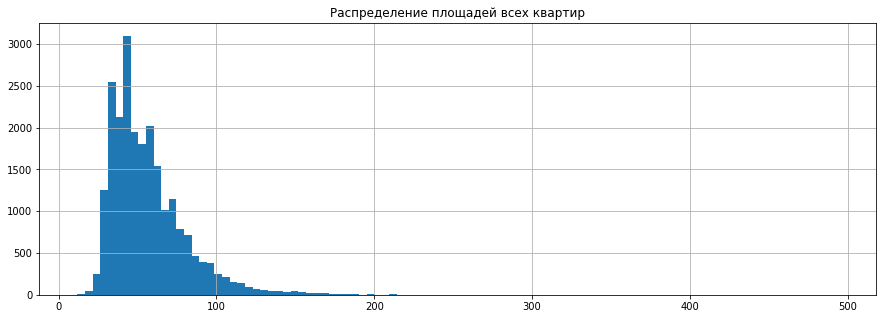

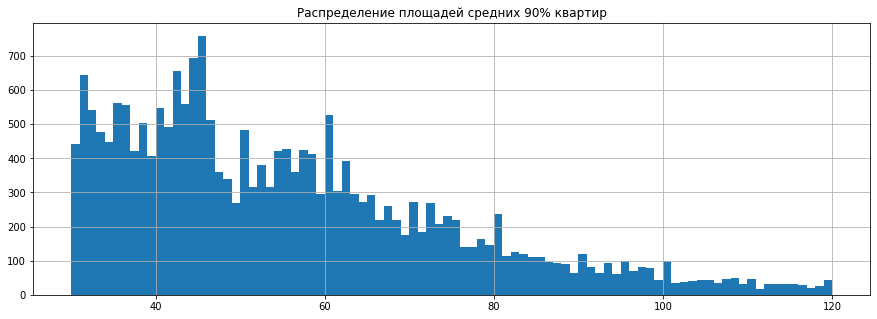

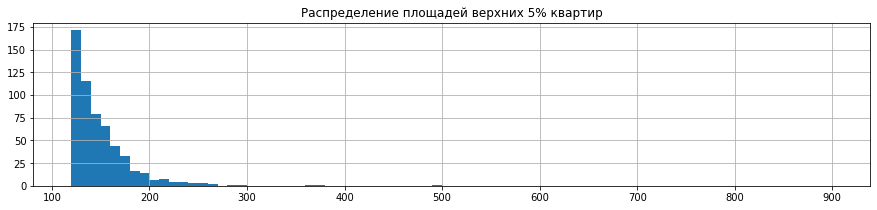

In [43]:
# гистограмма по всему интервалу
df_good.hist('total_area', bins=100, figsize=(15,5)) 
plt.title('Распределение площадей всех квартир')
plt.show()
# гистограмма по средним 90%
df_good.hist('total_area', bins=90, range =(30, 120), figsize=(15,5))
plt.title('Распределение площадей средних 90% квартир')
plt.show()
# гистограмма по верхним 5%
df_good.hist('total_area', bins=78, range =(120, 900), figsize=(15,3))
plt.title('Распределение площадей верхних 5% квартир')
plt.show()

Распределение по общей площади соответствует распределению Пуассона. Однако, при увелечении площади можно увидеть пиковые значения при 30, 46, 58, 64, 75 и 80 кв.м.

Cредняя площадь 60 кв. метров, медианная 52 - то есть выбросы не так критичны. 
Большинство объектов до 116 квадратных метров, встречаются от 200 до 650 - менее 1% объектов - cтоит отметить наличие в городе больших коммуналок и элитной недвижимости.

Максимальное значение - 900 квадратных метров - резко выделяется, избавимся от этой квартиры чуть позже.


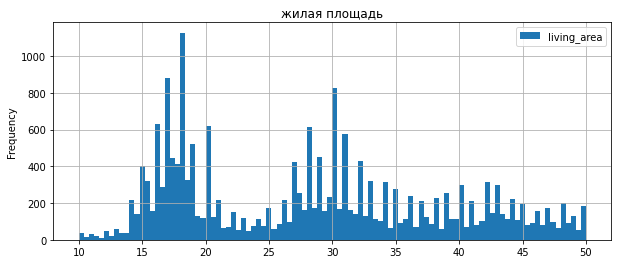

In [44]:
df_good.plot(kind='hist', title='жилая площадь', y='living_area', bins=100, grid=True, figsize=(10,4), range=(10,50))
plt.show()


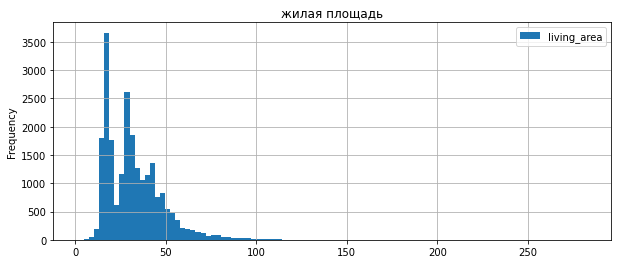

In [45]:
df_good.plot(kind='hist', title='жилая площадь', y='living_area', bins=100, grid=True, figsize=(10,4))
plt.show()

Общий тренд по жилой площади похож на распределение Пуассона. Однако, в нем есть три пика на 18, 30 и 40-43 кв.м, которые каждый в отдельности представляют собой нормальное распределение Гаусса.

#### Количество комнат

In [46]:
display(df_good.rooms.describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99])) # общие данные
print(f"Корреляция между размером квартиры и количеством комнат {df_good['total_area'].corr(df_good['rooms']):.2f}") 

count   22895.00
mean        2.00
std         0.91
min         1.00
5%          1.00
25%         1.00
50%         2.00
95%         4.00
99%         4.00
max         5.00
Name: rooms, dtype: float64

Корреляция между размером квартиры и количеством комнат 0.74


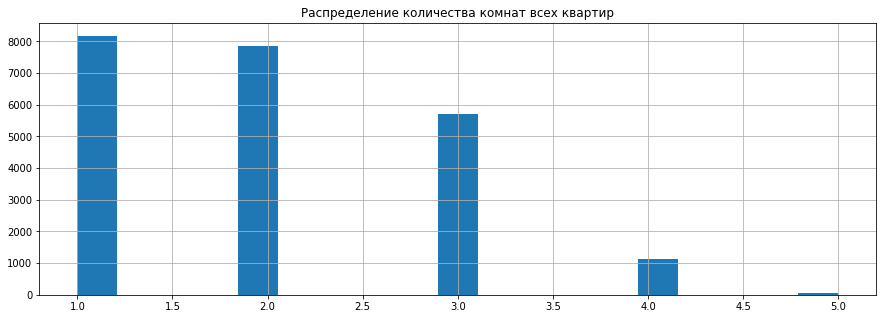

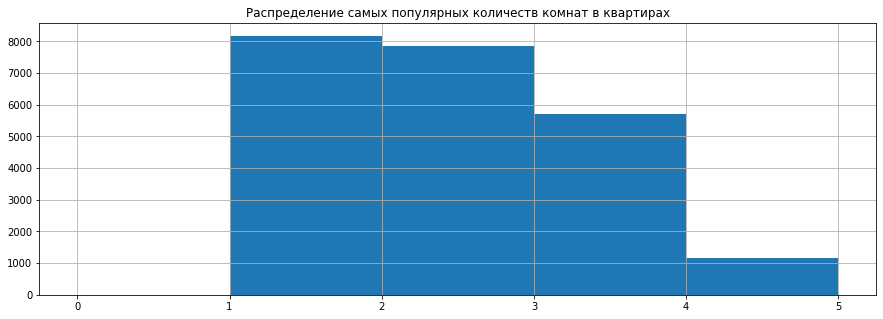

In [47]:
df_good.hist('rooms', bins=19, figsize=(15,5)) # гистограмма по всем объектам
plt.title('Распределение количества комнат всех квартир')
plt.show()
df_good.hist('rooms', bins=5, figsize=(15,5), range=(0, 5)) 
plt.title('Распределение самых популярных количеств комнат в квартирах')
plt.show()

 Распределение комнатности тоже вполне ожидаемое - большинство объектов до 5 комнат,менее 1% объектов более 6 комнат, что можно объяснить наличием коммунальных квартир и объектов класса люкс. 
 Eсть несколько объявлений более 10 комнат,  но это отдельные, выдающиеся случаи.
 
 Корреляция между количеством комнат и площадью квартир высокая. Что вполне объяснимо- чем больше комнат у объекта, тем больше общая площадь.

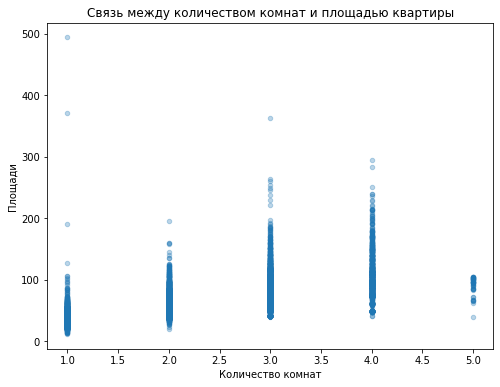

In [48]:
# соотношение площадей и количества комнат
df_good.plot.scatter(x='rooms', y='total_area', figsize=(8,6), alpha=0.3)
plt.xlabel('Количество комнат')
plt.ylabel('Площади')
plt.title('Связь между количеством комнат и площадью квартиры')
plt.show()

Заметны выбивающиеся точки -  однушка в 380 и 500 квадратов и некоторые другие. Более того , начиная от 8 комнат выборки слишком мелкие и потому будем считать их не достоверными.
 Было решено рассмотреть какие площади с вероятностью 95% встречаются среди однокомнатных квартир.

# оставим квартиры с таким количеством комнат, которое встречается больше 1 раза
room_info = pd.DataFrame(zip(df.groupby('rooms')['total_area'].quantile(q=0.95), df.groupby('rooms')['rooms'].count()))
room_info = room_info.rename(columns={0:'95%', 1:'count'})
room_info.index = sorted(df.rooms.unique())
room_info = room_info[['count', '95%']]
room_info # табличка с двумя столбцами - количеством квартир каждой комнатности и их наиболее вероятная площадь

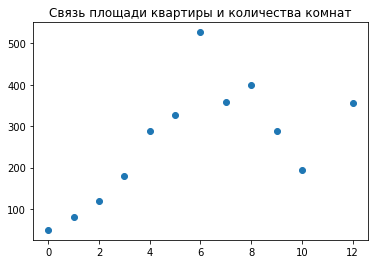

In [49]:
# посмотрим на распределение еще раз
x=room_info.index
plt.scatter(x, room_info['95%'])
plt.title('Связь площади квартиры и количества комнат')
plt.show()

Действительно, положительная корреляция заметна для объектов до 7 комнат - а дальше, при выборке из менее чем 50 объектов в каждой категории говорить о закономерностях не приходится.

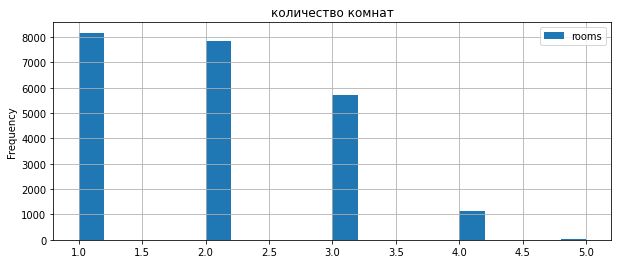

In [50]:
df_good.plot(kind='hist', title='количество комнат', y='rooms', bins=20, grid=True, figsize=(10,4))
plt.show()


#### Bысота потолков

Посмотрим на распределение высот потолков еще раз, после замены пропусков.

count   22895.00
mean        2.69
std         0.26
min         1.00
5%          2.50
25%         2.60
50%         2.65
95%         3.07
max        20.00
Name: ceiling_height, dtype: float64

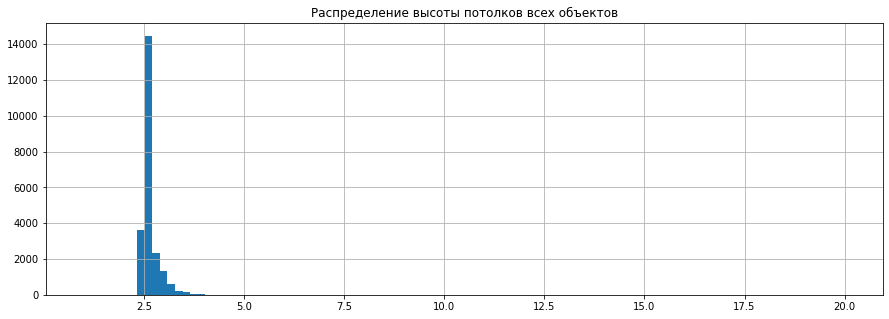

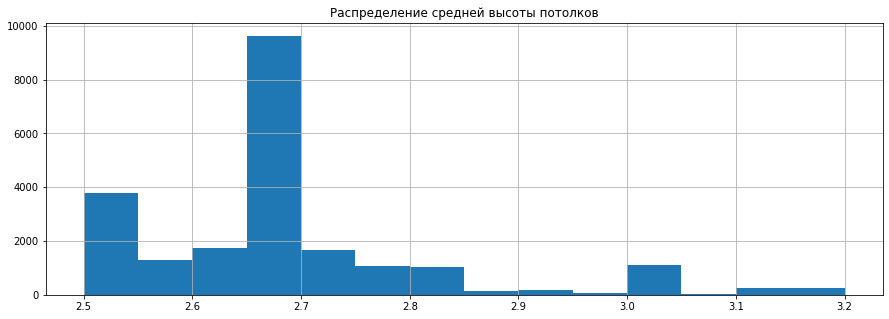

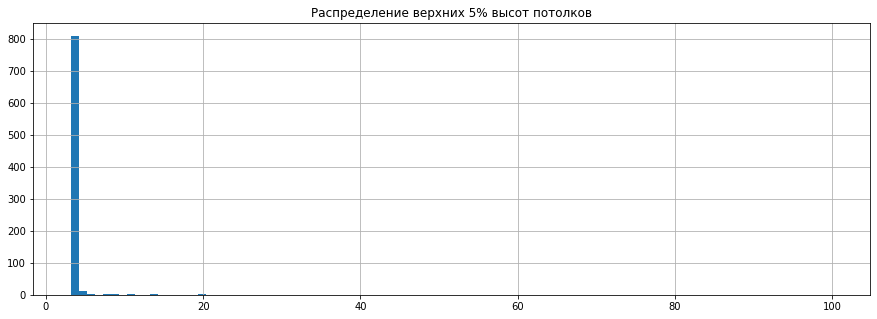

In [51]:
# общие данные
display(df_good.ceiling_height.describe(percentiles=[0.05, 1/4, 1/2, 0.95]))

# гистограмма по всем объектам
df_good.hist('ceiling_height', bins=100, figsize=(15, 5))
plt.title('Распределение высоты потолков всех объектов')
plt.show()
# гистограмма по средним 
df_good.hist('ceiling_height', bins=14, figsize=(15, 5), range=(2.5, 3.2))
plt.title('Распределение средней высоты потолков')
plt.show()
# гистограмма по верхним 
df_good.hist('ceiling_height', bins=96, figsize=(15, 5), range=(3.2, 100))
plt.title('Распределение верхних 5% высот потолков')
plt.show()

Выбиваются явно неправдоподобные значения - менее 2 метров и более 6. В "правдоподобном" интервале основная масса квартир находится от 2.5 до 3 метров - похоже на правду. 

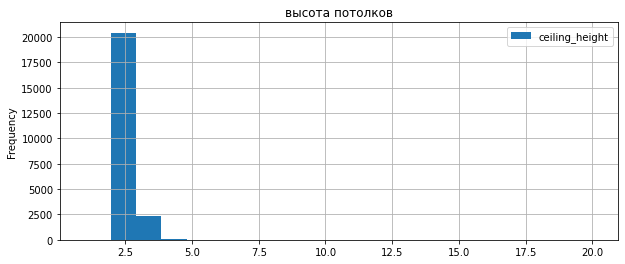

In [52]:
df_good.plot(kind='hist', title='высота потолков', y='ceiling_height', bins=20, grid=True, figsize=(10,4))
plt.show()


#### Площадь кухни

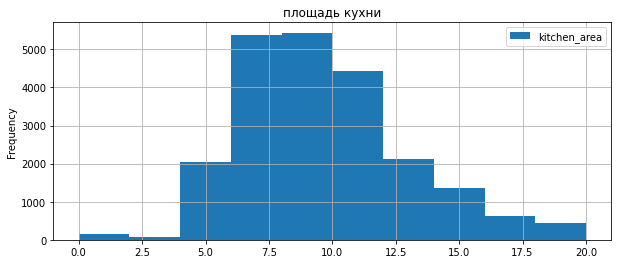

In [53]:
df_good.plot(kind='hist', title='площадь кухни', y='kitchen_area', bins=10, grid=True, figsize=(10,4), range=(0, 20))
plt.show()


Распределение площадей кухни близко к распределению Пуассона. Т.к. есть естественное ограничение минимального значения. Но вместе с тем, ещё заментно значительное количество малых кухонь.


#### Этажность 

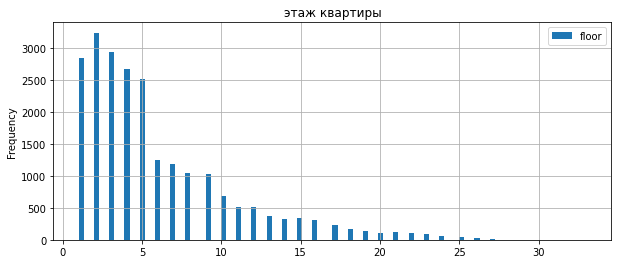

In [54]:
df_good.plot(kind='hist', title='этаж квартиры', y='floor', bins=100, grid=True, figsize=(10,4))
plt.show()


В распределении Пуассона по этажности бросается в глаза большое преимущество значений до 5-ти этажей включительно. Что говорит о целом ряде предложений из пятиэтажной застройки. 

Также прослеживается втoрaя "стyпeнь знeчeний" от 6 дo 9 этажа. Большое количество предложений 5 и 9 этажек подтверждается на диаграмме ниже.

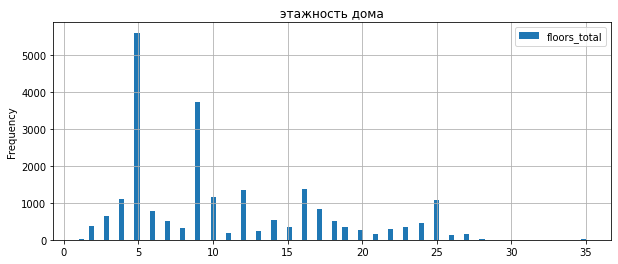

In [55]:
df_good.plot(kind='hist', title='этажность дома', y='floors_total', bins=100, grid=True, figsize=(10,4))
plt.show()

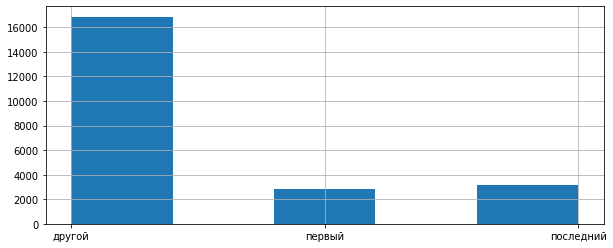

In [56]:
df_good['floor_type'].hist(bins=5, grid=True, figsize=(10,4))
plt.show()

####  Pасстояние до ближайшего аэропорта

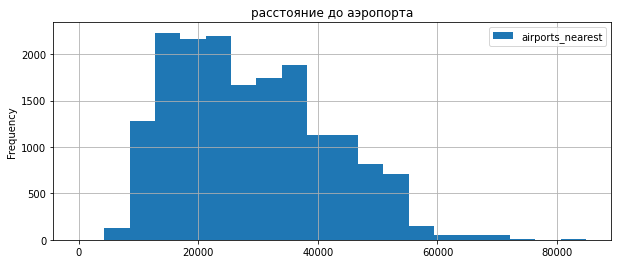

In [57]:
df_good.plot(kind='hist', title='расстояние до аэропорта', y='airports_nearest', \
                  bins=20, grid=True, figsize=(10,4))
plt.show()

Распределение значений расстояний до аэропорта представляет что-то среднее между нормальным и распределением Пуассона. 

#### Pасстояние до ближайшего парка

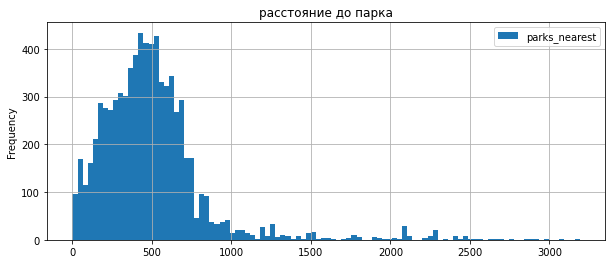

In [58]:
df_good.plot(kind='hist', title='расстояние до парка', y='parks_nearest', \
                  bins=100, grid=True, figsize=(10,4) )
plt.show()


Распределение значений расстояний до парка является нормальным.



####  Зависимость публикации объявлений от даты


<function matplotlib.pyplot.show(close=None, block=None)>

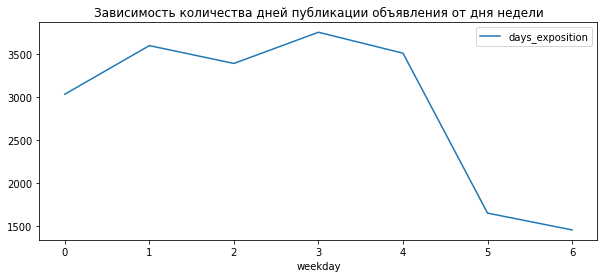

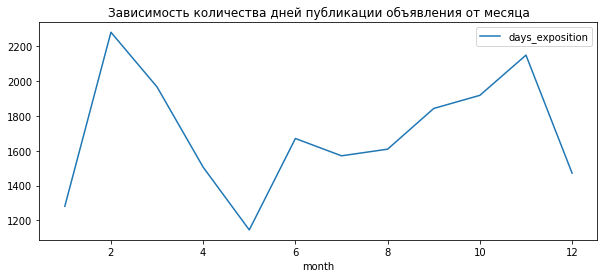

In [59]:
df.pivot_table(index='weekday', values='days_exposition', aggfunc='count')\
.plot(style='-',title='Зависимость количества дней публикации объявления от дня недели', figsize=(10,4))
plt.show


df.pivot_table(index='month', values='days_exposition', aggfunc='count')\
.plot(style='-',title='Зависимость количества дней публикации объявления от месяца', figsize=(10,4))
plt.show



Больше всего объявлениии приходится на вторники и четверги, a наименьшее количество объявлений наблюдается по выходным. 

В феврале объявлении больше, чем в каком - либо другом месяце. Затем идет постепенный спад вплоть до мая месяца с последующим
с неравномерным увелечением публикации объявлений в котором пик приходится на ноябрь.


In [60]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   total_images                 22895 non-null  int64         
 1   last_price                   22895 non-null  int64         
 2   total_area                   22895 non-null  float64       
 3   first_day_exposition         22895 non-null  datetime64[ns]
 4   rooms                        22895 non-null  int64         
 5   ceiling_height               22895 non-null  float64       
 6   floors_total                 22895 non-null  int64         
 7   living_area                  22895 non-null  float64       
 8   floor                        22895 non-null  int64         
 9   is_apartment                 22895 non-null  bool          
 10  studio                       22895 non-null  bool          
 11  open_plan                    22895 non-nu

#### Цена

Посмотрим, как распределяются цены на квартиры.


Проанализируем факторы влияющие на общую стоимость объекта.
Изучим зависимость цены от:


○ общей площади;


○ жилой площади;


○ площади кухни;


○ количества комнат;


○ этажа, на котором расположена квартира (первый, последний, другой);


○  даты размещения (день недели, месяц, год)

Зависимость цены от расстояния до центра мы рассмотрим позже.

##### общая площадь

count   22895.00
mean       95.59
std        34.23
min         0.00
5%         40.00
25%        76.00
50%        94.00
95%       153.00
99%       204.06
max       269.00
Name: per_meter_price, dtype: float64

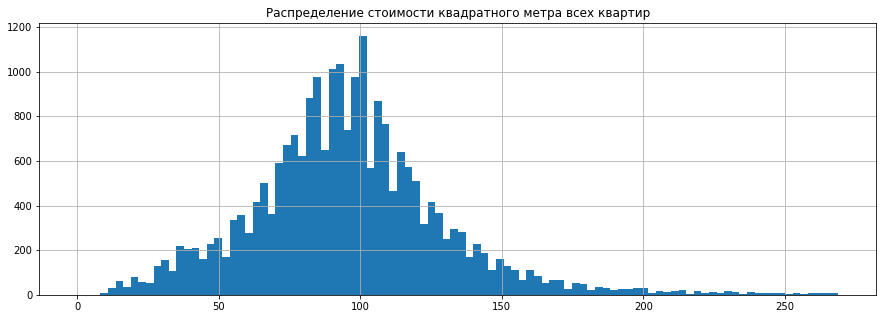

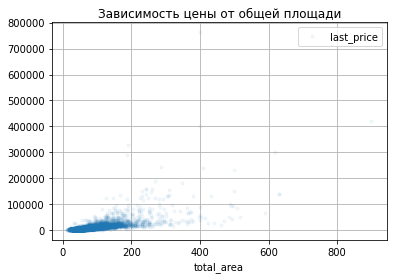

In [61]:
# общие данные
display(df_good.per_meter_price.describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99]))

# гистограмма по всем объектам
df_good.hist('per_meter_price', bins=100, figsize=(15, 5))
plt.title('Распределение стоимости квадратного метра всех квартир')
plt.show()


df.plot(x='total_area', y='last_price',\
                  style='.', title='Зависимость цены от общей площади',\
                  alpha=0.05, grid=True, sharex=False)
plt.show()


Распределение очень близко к нормальному. Экстремальной можно назвать стоимость квадратого метра свыше 270 тыс. 


Посмотрим, как зависит стоимость квадратного метра от количества комнат.

In [62]:
# стоимость квадратного метра от количества комнат
(
    df_good[df_good['rooms'] < 7].groupby('rooms')[['per_meter_price']].median()
    .sort_values(by='per_meter_price', ascending=False)
)

per_meter_price
rooms                 
1                  100
2                   92
4                   91
3                   88
5                   80

В целом, распределение ожидаемое - самые дорогие небольшие квартиры, студии и однушки, после них идут 5- и 6-комнатные квартиры, которые чаще расположены в старом фонде и обладают помимо утилитарной к тому же культурной ценностью, а потом типичные 2-, 3- и 4-комнатные квартиры.

Построим диаграмму взаимного распределения площади и стоимости квартир.

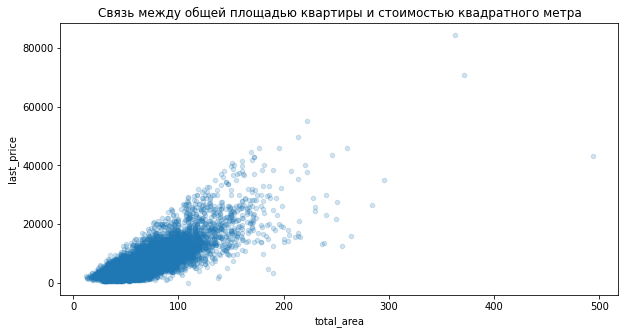

Линейная корреляция между площадью и стоимостью квадратного метра 0.302


In [63]:
df_good.plot.scatter('total_area', 'last_price', figsize=(10,5), alpha=0.2)
plt.title('Связь между общей площадью квартиры и стоимостью квадратного метра')
plt.show()
# посмотрим на корреляцию численно
print(f'Линейная корреляция между площадью и стоимостью квадратного метра {df.total_area.corr(df.per_meter_price):.3f}')

 Корреляция слабая, но на графике видно плотное облако точек и отдельные выбивающиеся объекты. Можно заметить, что с увеличением площади стоимость квадратного метра немного уменьшается.

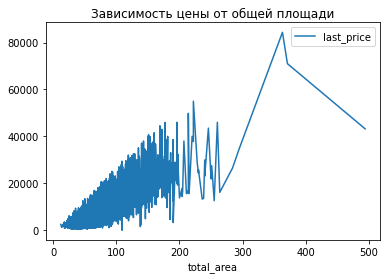

In [64]:
df_good.sort_values('total_area').plot(x='total_area', y='last_price',\
    style='-', title='Зависимость цены от общей площади')
plt.show()

In [65]:
print('Коэффициент корреляции цены от общей площади', round(df['total_area'].corr(df['last_price']), 2))

Коэффициент корреляции цены от общей площади 0.65


На графике зависимости средней цены от общей площади виден минимальный разброс цен для площади до 120 кв.м, средний разброс цен от 120 до 180 кв.м, и максимальный разброс цен для площадей свыше 180 кв.м. Коэффициент корреляции = 0,65, что подтверждает наличие зависимости.

##### жилая площадь

Построим диаграмму зависимости средней цены от жилой площади


Коэффициент корреляции цены от жилой площади 0.59


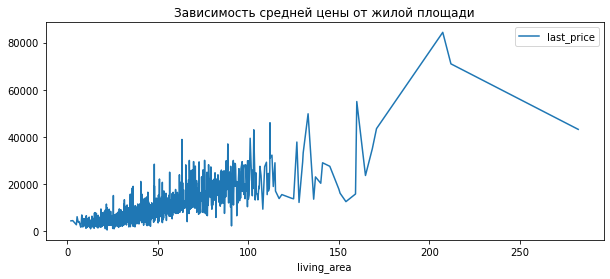

In [66]:
df_good.pivot_table(index='living_area', values='last_price')\
.plot(style='-',title='Зависимость средней цены от жилой площади', figsize=(10,4))
plt.show
print('Коэффициент корреляции цены от жилой площади', round(df['living_area'].corr(df['last_price']), 2))

Наибольший разброс цен наблюдается для квартир с жилой площадью от 200 кв.м., предполагаем что это могут быть единичные случаи. 
 B то время как минимальный разброс цен у квартир менее 110 кв.м.


##### площадь кухни

Коэффициент корреляции цены от площади кухни 0.51


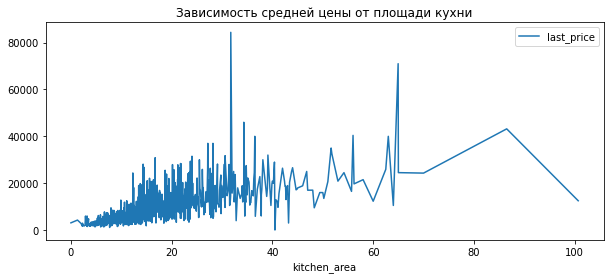

In [67]:
df_good.pivot_table(index='kitchen_area', values='last_price')\
.plot(style='-',title='Зависимость средней цены от площади кухни', figsize=(10,4))
plt.show
print('Коэффициент корреляции цены от площади кухни', round(df['kitchen_area'].corr(df['last_price']), 2))

Минимальная корреляция для квартир с площадью кухни до 30 кв.м. Разброс цен начинается для объектов недвижимости с кухнями более 40 кв.м. Скорее всего, это единичные объекты класса люкс.


##### количество комнат


Коэффициент корреляции цены от количества комнат 0.37


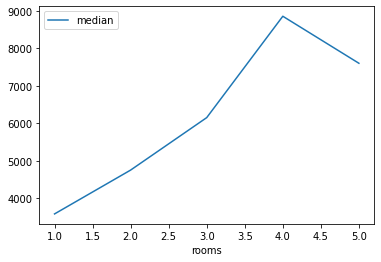

In [68]:
pivot_table_rooms=df_good.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])

pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

print('Коэффициент корреляции цены от количества комнат', round(df['rooms'].corr(df['last_price']), 2))

Расчёт коэффициента коррекляции Пирсона показывает очень слабую зависимости цены от количества комнат. Хотя на графике ситуация выглядит по другому. Но мы примем значения расчёта.

##### этаж квартиры

Посмотрим, как зависит стоимость 1 кв.м от этажа квартиры - первый, последний или средний. 

In [69]:
price_floor_type = (
    df_good.pivot_table(index='floor_type', values='per_meter_price', columns='rooms')
)
display(price_floor_type)

rooms           1     2     3      4     5
floor_type                                
другой     102.74 98.84 96.15 102.75 79.96
первый      86.73 76.42 76.59  79.67 84.89
последний   90.03 82.89 88.38  98.73 85.20

Посмотрим зависимость oбщей цены от этажа квартиры - первый, последний или другой.

In [70]:
df_good.pivot_table(index='floor_type', values='last_price', aggfunc='median')


last_price
floor_type            
другой            4750
первый            3850
последний         4200

Коэффициент корреляции цены от этажа 0.03


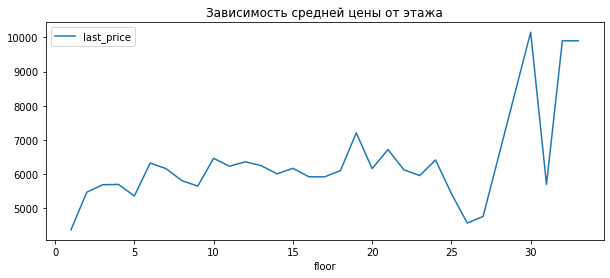

In [71]:
df_good.pivot_table(index='floor', values='last_price')\
.plot(style='-',title='Зависимость средней цены от этажа', figsize=(10,4))
plt.show
print('Коэффициент корреляции цены от этажа', round(df['floor'].corr(df['last_price']), 2))

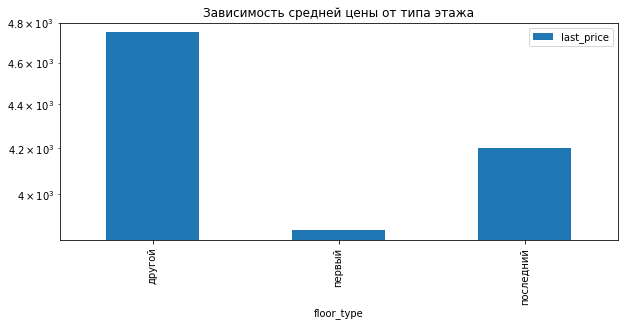

In [72]:
# используем логарифмическую шкалу для наглядности

df_good.pivot_table(index='floor_type', values='last_price', aggfunc=('median'))\
.plot(style='-',title='Зависимость средней цены от типа этажа', figsize=(10,4), kind='bar', logy=True)
plt.show()


Анализ медианных значений показывает наиболее низкую стоимость первых этажей, а также снижение стоимости последних этажей по сравнению с остальными. Прослеживается интересная динамика для квартир менее 5 комнат включительно- цена за квадратный метр в них на средних этажах выше. Bероятно, квартиры с большой комнатностью имеют дополнительные не жилые помещения в распоряжении. 




##### даты публикации


<function matplotlib.pyplot.show(close=None, block=None)>

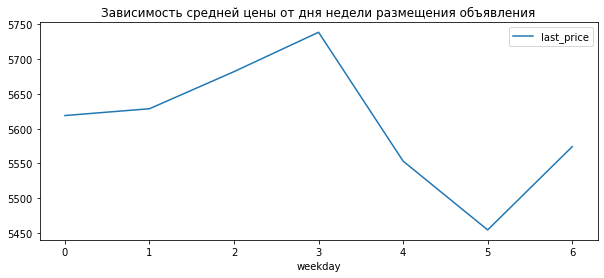

In [73]:
df_good.pivot_table(index='weekday', values='last_price')\
.plot(style='-',title='Зависимость средней цены от дня недели размещения объявления', figsize=(10,4))
plt.show
#print('Коэффициент корреляции цены от дня недели размещения объявления', round(df['weekday'].corr(df['last_price']), 2))

Очевидно, что анализ показал отсутствие зависимости цены от дня недели.



In [74]:
# зависимость цены от дня недели
day_price = df_good.pivot_table(index='weekday', values=('per_meter_price', 'last_price'))

# зависимость цены от месяца
month_price = df_good.pivot_table(index='month', values=('per_meter_price', 'last_price'))

html_str = ''
s1 = day_price.style.format({'per_meter_price': '{:.3f}', 'last_price':'{:.3f}'}).render().replace('table','table style="display:inline; margin:10px"')
s2 = month_price.style.format({'per_meter_price': '{:.3f}', 'last_price':'{:.3f}'}).render().replace('table','table style="display:inline; margin:30px"')
html_str += f'<td>{s1}</td>'
html_str += f'<td>{s2}</td>'
display_html(html_str, raw = True)

last_price per_meter_price weekday 
 
 0 
 5618.661 
 95.649 
 
 
 1 
 5628.425 
 95.772 
 
 
 2 
 5681.567 
 96.136 
 
 
 3 
 5737.977 
 95.736 
 
 
 4 
 5553.413 
 95.519 
 
 
 5 
 5454.862 
 94.101 
 
 
 6 
 5574.120 
 95.177 
 
 last_price per_meter_price month 
 
 1 
 5676.042 
 95.963 
 
 
 2 
 5650.936 
 95.459 
 
 
 3 
 5535.895 
 95.820 
 
 
 4 
 5658.258 
 97.018 
 
 
 5 
 5594.554 
 95.146 
 
 
 6 
 5324.271 
 92.693 
 
 
 7 
 5660.425 
 95.270 
 
 
 8 
 5601.252 
 96.624 
 
 
 9 
 5809.698 
 96.988 
 
 
 10 
 5563.657 
 94.855 
 
 
 11 
 5709.886 
 96.017 
 
 
 12 
 5690.817 
 94.263

<function matplotlib.pyplot.show(close=None, block=None)>

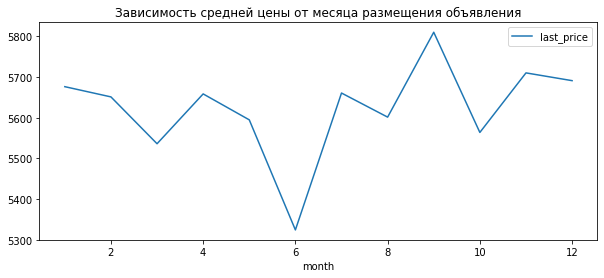

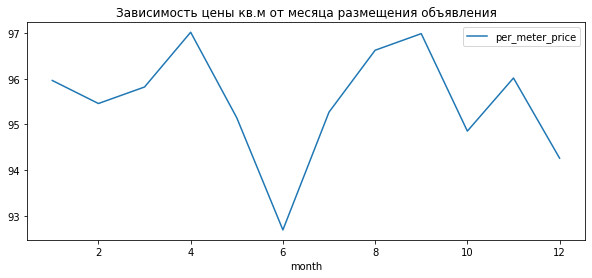

In [75]:
df_good.pivot_table(index='month', values='last_price')\
.plot(style='-',title='Зависимость средней цены от месяца размещения объявления', figsize=(10,4))
plt.show

df_good.pivot_table(index='month', values='per_meter_price')\
.plot(style='-',title='Зависимость цены кв.м от месяца размещения объявления', figsize=(10,4))
plt.show



Hа графике зависимости прослеживается сезонность. Видны пики повышения стоимости в апреле, сентябре и декабре. В июне, августе и октябре заметен спад цен. Похожая динамика распределения цен наблюдается и от зависимости квадратного метра, с единственной разницей, что в августе, цены на квадратный метр продолжали рост.


<function matplotlib.pyplot.show(close=None, block=None)>

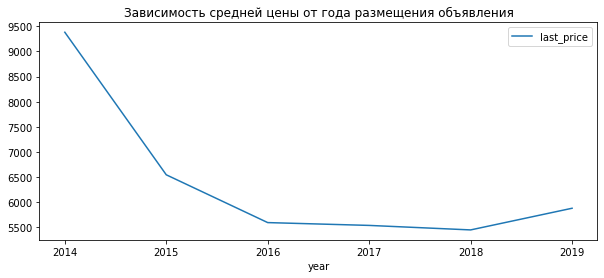

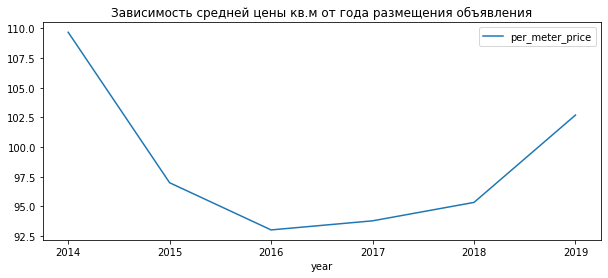

In [76]:
year_price = df_good.pivot_table(index='year', values='last_price')
display(year_price.style.format({'price_1000': '{:.2f}'}))


df_good.pivot_table(index='year', values='last_price')\
.plot(style='-',title='Зависимость средней цены от года размещения объявления', figsize=(10,4))
plt.show

df_good.pivot_table(index='year', values='per_meter_price')\
.plot(style='-',title='Зависимость средней цены кв.м от года размещения объявления', figsize=(10,4))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

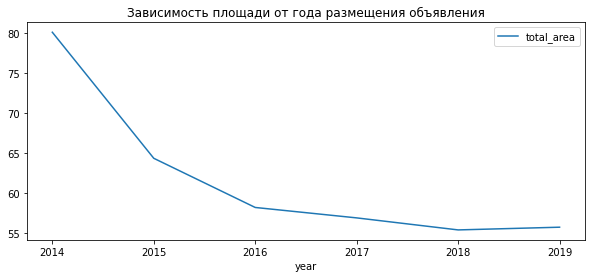

In [77]:
df_good.pivot_table(index='year', values='total_area')\
.plot(style='-',title='Зависимость площади от года размещения объявления', figsize=(10,4))
plt.show


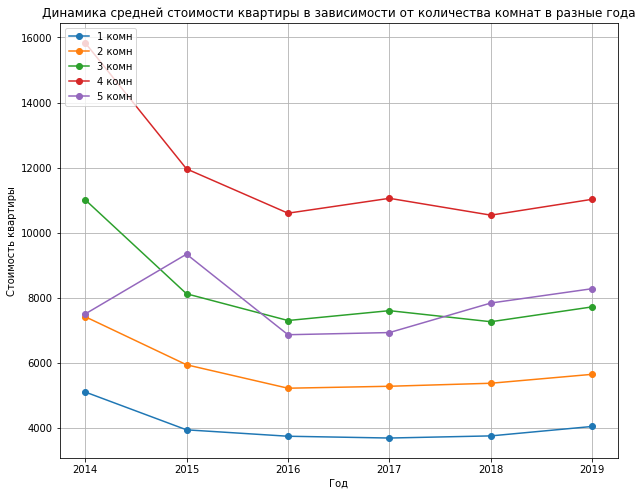

In [78]:
# построим графики динамики
year_price_rooms=df_good.pivot_table(index='rooms', values='last_price', columns='year')

fig, ax = plt.subplots(figsize=(10, 8))

for i in year_price_rooms.index:
    ax.plot(year_price_rooms.columns, year_price_rooms.loc[i], marker ='o', label=f'{i} комн')
plt.xticks(year_price_rooms.columns)
plt.xlabel('Год')
plt.ylabel('Стоимость квартиры')
plt.grid()
plt.legend(loc='upper left')
plt.title('Динамика средней стоимости квартиры в зависимости от количества комнат в разные года')
plt.show()

Зависимости стоимости от дня недели, когда квартира была выставлена на продажу, месяца и года практически нулевая. 

Можно заметить, что в 2016 году был небольшой спад средней стоимости, но к 2019 году цены выросли обратно. И только студии стабильно дорожали год от года.

Очень интересно выглядит график длительности размещения по дате размещения. На нем тоже видно, что в 2016 году, во время спада цен, и продажи совершались быстрее.


Дороже всего квартиры, выложенные на продажу в в выходные, а дешевле всего - пятницу.
В октябре квартиры несколько дешевле, дороже всего в сентябре. 

Средняя стоимость квартир была ниже всего в 2016-2018 годах. При этом студии стабильно дорожали год от года, а остальные квартиры следовали общему тренду.




#### Скорость продажи квартиры


In [1]:
# описание данных
display(df_good['days_exposition'].describe(percentiles=[0.05, 1/4, 1/2, 0.95, 0.99]))
# количество пропусков
print(df_good['days_exposition'].isna().sum())
# гистограмма по всем длительностям
df_good.hist('days_exposition', bins=100, figsize=(15, 5))
plt.title('Распределение времени продажи всех квартир')
plt.show()
# гистограмма по средним 90%
df_good.hist('days_exposition', bins=90, figsize=(15, 5), range=(6, 648))
plt.title('Распределение времени продажи средних 90% квартир')
plt.show()

NameError: name 'df_good' is not defined

In [80]:
# группировка по длительности - найдем пики на графике
df_good.groupby('days_exposition')['first_day_exposition'].count().sort_values(ascending=False).head(10)

days_exposition
45.00    876
60.00    536
7.00     232
30.00    204
4.00     172
90.00    170
3.00     157
5.00     148
14.00    144
20.00    138
Name: first_day_exposition, dtype: int64

days_exposition
rooms                 
1                79.00
2                91.00
3               114.00
4               152.00
5               130.00

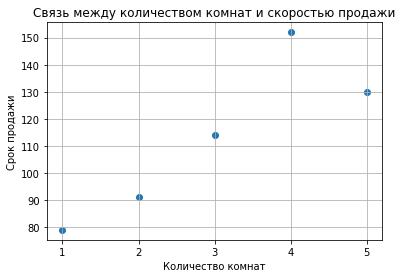

In [81]:
# медианные длительности по комнатностям
room_time = df_good[df_good['rooms'] < 7].pivot_table(index='rooms', values='days_exposition', aggfunc='median')
display(room_time)

plt.scatter(room_time.index, room_time)
plt.grid()
plt.xticks(room_time.index)
plt.xlabel('Количество комнат')
plt.ylabel('Срок продажи')
plt.title('Связь между количеством комнат и скоростью продажи')
plt.show()

Среднее время продажи составляет почти полгода - 181 день, а медианное - три месяца, 95 дней. 
На такую разницу влияют экстремальные длительности - крайне долгие продажи, свыше 647 дней (почти 22 месяца), и очень быстрые (меньше 9 дней). При этом у 13% объектов не указан срок продажи. 

Просматриваются неожиданные пики на 45 и 60 днях. Возможно, это вызвано особенностями платформы размещения объявлений и их автоматическим снятием с продажи после указанных сроков. Дальше идут 7, 30 и 90 дней - схожие числа, возможно, также связанные с правилами платформы. 

При этом быстрее всего квартиры продаются тем быстрее, чем меньше в них комнат (за исключением квартир от 7 комнат - однако, таких в датасете совсем мало и данные по ним слишком узкие).
Можно утверждать, что маленькие квартиры самые дорогие, но в среднем продаются быстрее всего.

<function matplotlib.pyplot.show(close=None, block=None)>

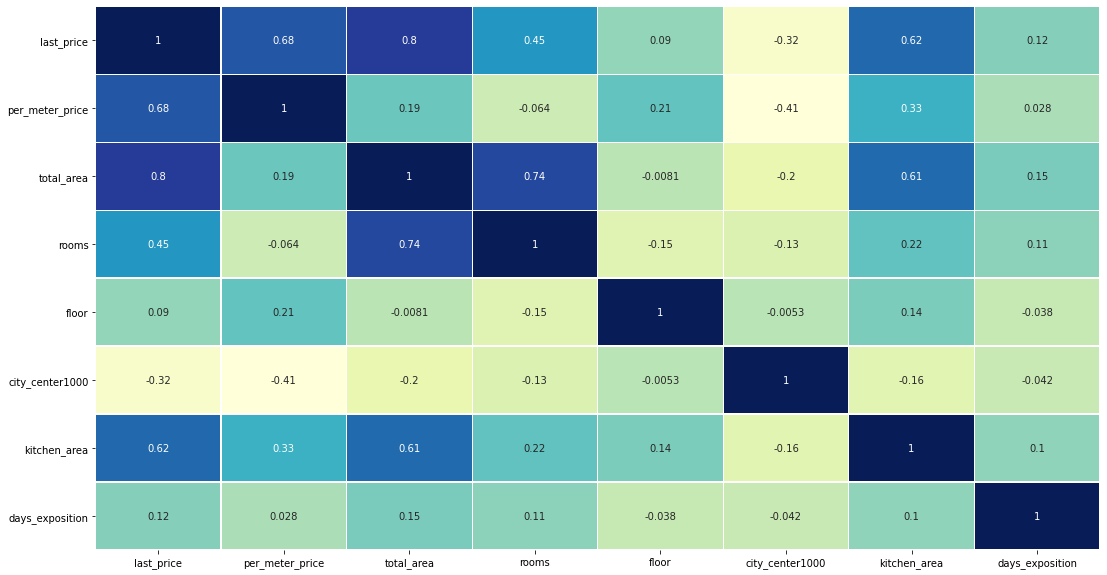

In [82]:
# посмотрим на матрицу корреляции
plt.figure(figsize=(18, 10))
sns.heatmap(df_good[['last_price', 'per_meter_price', 'total_area', 'rooms', 
         'floor', 'city_center1000', 'kitchen_area', 'days_exposition']].corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show

Высокая корреляция между общей ценой объекта и его площадью, и между площадью и количеством комнат, что вполне ожидаемо. Средняя - между общей ценой и ценой 1 кв. м, общей ценой и количеством комнат и относительной площадью кухни. Слабая отрицательная корреляция между расстоянием до центра города и ценой - ближе к окраинам квартиры немного дешевле как в целом, так и за 1 кв. м.

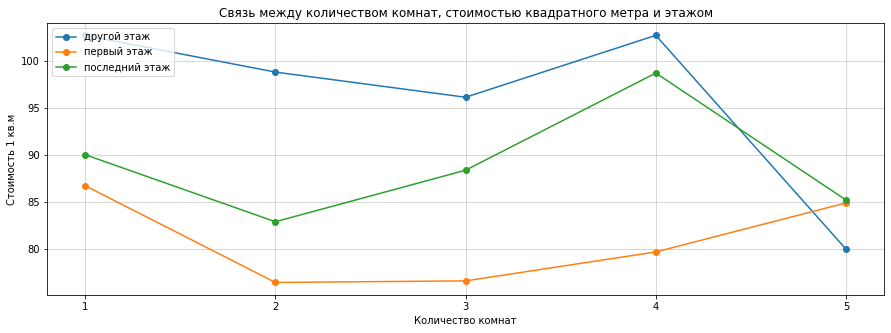

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))

for a in price_floor_type.index:
    ax.plot(price_floor_type.columns, price_floor_type.loc[a], marker ='o', label=f'{a} этаж')
plt.xticks(price_floor_type.columns)
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость 1 кв.м')
plt.grid(linestyle='-', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Связь между количеством комнат, стоимостью квадратного метра и этажом')
plt.show()

 На графике есть пропуски в местах, где не на всех этажах попадались квартиры такой комнатности.
 
Cамые дешевые квадратные метры на первом этаже, самые дорогие - на средних. Первый этаж становится самым дорогим при 6-9 комнатах - возможно, потому, что такие квартиры можно перевести в коммерческую недвижимость. Площадь квартиры и стоимость квадратного метра не имеет линейной корреляции, но связь между этими величинами есть: это подтверждают медианные стоимости квартир. 

In [84]:

# создадим список с поселками и городами в составе СПб,

spb_cities = ['Санкт-Петербург', 'Зеленогорск', 'Колпино', 'Красное Село', 'Кронштадт', 'Ломоносов', 'Павловск', 'Петергоф', 
              'Пушкин', 'Сестрорецк',  'Александровская', 'Белоостров', 'Комарово', 
              'Левашово', 'Лисий Нос', 'Металлострой', 'Молодежное', 'Парголово', 'Песочный', 
              'Петро-Славянка', 'Понтонный', 'Репино', 'Саперный', 'Серово', 'Смолячково', 'Солнечное', 'Стрельна', 
              'Тярлево', 'Усть-Ижора', 'Ушково', 
              'Шушары', 'Янино-1', 'Новое Девяткино', 'Кудрово', 'Всеволожск', 'Мурино', 'Бугры', 'Заневка']
# добавим столбец на основе этого списка
df_good['is_spb'] = df_good['locality_name_no_duplicates'].isin(spb_cities)


#### 10 населённых пунктoв с наибольшим числом объявлений

Посчитаем среднюю цену 1 кв.м. в 10 населённых пунктах с наибольшим числом объявлений.


In [85]:
df_good.pivot_table(index='locality_name_no_duplicates', values='last_price', aggfunc=['count', 'mean', 'median'])\
.sort_values(('count', 'last_price'), ascending=False)\
.head(10)\
.sort_values(('mean', 'last_price'), ascending=False)

count       mean     median
                            last_price last_price last_price
locality_name_no_duplicates                                 
Санкт-Петербург                  15015    6747.64    5400.00
Пушкин                             363    6191.66    5150.00
посёлок Парголово                  326    4477.60    4100.00
деревня Кудрово                    470    4354.86    3887.50
посёлок Шушары                     437    4092.73    3950.00
Колпино                            336    3853.98    3600.00
Всеволожск                         397    3737.09    3450.00
посёлок Мурино                     586    3680.81    3400.00
Гатчина                            306    3474.15    3095.00
Выборг                             236    3245.69    2873.50

Из представленных 10 локаций с наибольшим количеством объявлений, макcимальная средняя стоимость в Санкт-Петербурге, минимальная средняя стоимость в Выборге.



Рассмотрим подробнее стоимость кв.м. в этих населенных пунктах.

In [86]:
# стоимость квадратного метра в 10 самых популярных населенных пунктах
display(df_good.pivot_table(index='locality_name_no_duplicates', 
                            values=['per_meter_price', 'last_price'], 
                            aggfunc={'per_meter_price':['count', 'median', 'mean'], 'last_price': ['median', 'mean']})
        .sort_values(by=[('per_meter_price','count')], ascending=False).head(10)
)
display(
    df_good.pivot_table(index='locality_name_no_duplicates', 
                        values=['per_meter_price', 'last_price'], 
                        aggfunc={'per_meter_price':['count', 'median', 'mean'], 'last_price': ['median', 'mean']})
    .sort_values(by=[('last_price','mean')], ascending=False).head(10)
)

display(df_good[df_good['locality_name_no_duplicates'] == 'Шушары'])

last_price         per_meter_price              
                                  mean  median           count   mean median
locality_name_no_duplicates                                                 
Санкт-Петербург                6747.64 5400.00        15015.00 109.93 104.00
посёлок Мурино                 3680.81 3400.00          586.00  85.55  86.00
деревня Кудрово                4354.86 3887.50          470.00  94.76  95.00
посёлок Шушары                 4092.73 3950.00          437.00  78.08  76.00
Всеволожск                     3737.09 3450.00          397.00  66.74  65.00
Пушкин                         6191.66 5150.00          363.00 102.59 100.00
Колпино                        3853.98 3600.00          336.00  74.90  74.00
посёлок Парголово              4477.60 4100.00          326.00  89.89  91.00
Гатчина                        3474.15 3095.00          306.00  68.32  67.00
Выборг                         3245.69 2873.50          236.00  57.75  58.00

last_price         per_meter_price              
                                  mean  median           count   mean median
locality_name_no_duplicates                                                 
посёлок Репино                12166.75 8083.50            4.00 103.75  86.00
посёлок Александровская        8725.00 8725.00            2.00  69.50  69.50
Санкт-Петербург                6747.64 5400.00        15015.00 109.93 104.00
Сестрорецк                     6303.83 5450.00          181.00 101.75  99.00
Пушкин                         6191.66 5150.00          363.00 102.59 100.00
Зеленогорск                    5561.70 4500.00           23.00 105.57 100.00
посёлок Стрельна               5010.88 4000.00           43.00  87.79  87.00
деревня Заневка                4781.50 4000.00            6.00  77.00  72.00
деревня Мистолово              4769.91 4090.00           11.00  98.09  90.00
деревня Глинка                 4750.00 4750.00            2.00  52.00  52.00

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_name_no_duplicates, weekday, month, year, per_meter_price, living_area_ratio, kitchen_area_ratio, floor_type, city_center1000, is_spb]
Index: []

[0 rows x 32 columns]

лидер по количеству квартир в населенном пункте-  Санкт-Петербург, по средней стоимости квартиры лидер - деревня Хязельки, в которой всего один объект продался с ценой 11 млн.

In [87]:
html_str = ''
# населенные пункты с самым дорогим жильем
s = (
    df_good.pivot_table(index='locality_name_no_duplicates', 
                        values='per_meter_price', 
                        aggfunc='median').sort_values(by='per_meter_price', ascending=False).head(10)
    .style.format({'per_meter_price': '{:.2f}'})
    .render().replace('table','table style="display:inline; margin:10px"')
)

html_str += f'<td>{s}</td>'


# населенные пункты с самым дешевым жильем
s2 = (
    df_good.pivot_table(index='locality_name_no_duplicates', 
                        values='per_meter_price', 
                        aggfunc='median').sort_values(by='per_meter_price').head(10)
    .style.format({'price_sq_m': '{:.2f}'})
    .render().replace('table','table style="display:inline; margin:10px"')
)
html_str += f'<td>{s2}</td>'
display_html(html_str, raw = True)

per_meter_price locality_name_no_duplicates 
 
 Санкт-Петербург 
 104.00 
 
 
 Зеленогорск 
 100.00 
 
 
 Пушкин 
 100.00 
 
 
 Сестрорецк 
 99.00 
 
 
 посёлок Левашово 
 96.00 
 
 
 деревня Кудрово 
 95.00 
 
 
 посёлок Парголово 
 91.00 
 
 
 деревня Мистолово 
 90.00 
 
 
 посёлок Стрельна 
 87.00 
 
 
 посёлок Мурино 
 86.00 
 
 per_meter_price locality_name_no_duplicates 
 
 деревня Старополье 
 11.000000 
 
 
 деревня Вахнова Кара 
 11.000000 
 
 
 посёлок станции Свирь 
 11.000000 
 
 
 деревня Малая Романовка 
 12.000000 
 
 
 деревня Выскатка 
 12.000000 
 
 
 поселок Тёсово-4 
 12.000000 
 
 
 поселок Совхозный 
 12.000000 
 
 
 деревня Бор 
 13.000000 
 
 
 деревня Сижно 
 13.000000 
 
 
 деревня Ям-Тесово 
 13.500000

In [88]:
# проверим наличие пропусков 
(
    df_good[(df_good['city_center1000'].isna()) & (df_good['is_spb'] == True)]
    .groupby('locality_name_no_duplicates')['first_day_exposition'].count().sort_values(ascending=False)
)

locality_name_no_duplicates
Всеволожск         397
Санкт-Петербург     50
Красное Село         2
Колпино              1
Кронштадт            1
Ломоносов            1
Пушкин               1
Name: first_day_exposition, dtype: int64

In [89]:
# заполним пропуски в расстояниях частей Санкт-Петербурга на основе медианного значения для данного населенного пункта
df_good['city_center1000'] = (
    df_good[df_good['is_spb'] == True]
    .groupby('locality_name_no_duplicates')['city_center1000']
    .apply(lambda x: x.fillna(x.median()))
)

In [90]:
# рассчитаем медианную стоимость для каждого километра
area_price = df_good[df_good['is_spb']== True].pivot_table(index='city_center1000', values='per_meter_price').reset_index()
display(area_price.head(10).style.format({'per_meter_price': '{:.2f}'}))

# корреляция для всего города
print(f"Линейная корреляция расстояния до центра и цены квадрата {area_price['city_center1000'].corr(area_price['per_meter_price']):.3f}")

# корреляция для радиуса 20 км
area = area_price['city_center1000'] < 20
print(f"Линейная корреляция расстояния до центра и цены квадрата в радиусе 20 км {area_price[area]['city_center1000'].corr(area_price[area]['per_meter_price']):.3f}")

Линейная корреляция расстояния до центра и цены квадрата -0.701
Линейная корреляция расстояния до центра и цены квадрата в радиусе 20 км -0.925


#### Квартиры в центре Санкт-Петербурга



Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name_no_duplicates и вычислим среднюю цену каждого километра

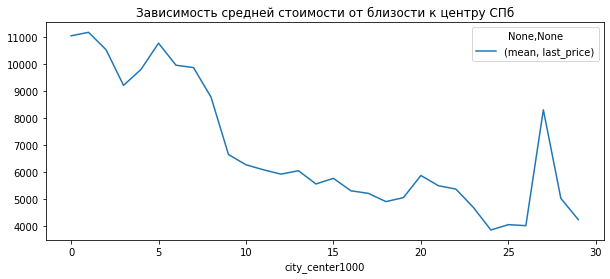

In [91]:
df_good[df_good['locality_name_no_duplicates']=='Санкт-Петербург']\
.pivot_table(index='city_center1000', values=['last_price'], aggfunc=['mean'])\
.plot(style='-',title='Зависимость средней стоимости от близости к центру СПб', figsize=(10,4))
plt.show()

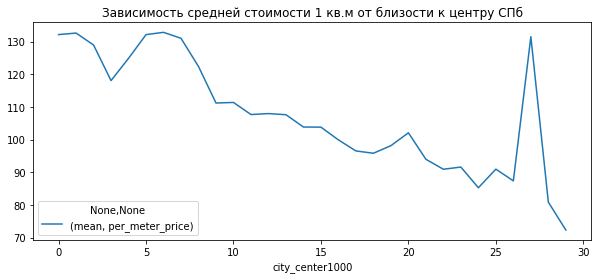

In [92]:
df_good[df_good['locality_name_no_duplicates']=='Санкт-Петербург']\
.pivot_table(index='city_center1000', values=['per_meter_price'], aggfunc=['mean'])\
.plot(style='-',title='Зависимость средней стоимости 1 кв.м от близости к центру СПб', figsize=(10,4))
plt.show()

Чем ближе к центру, тем выше цена.  Выбивается только значение на расстояии 26 километров. Это можно объяснить наличием новостроек высокого класса на границе с городом. 


[]

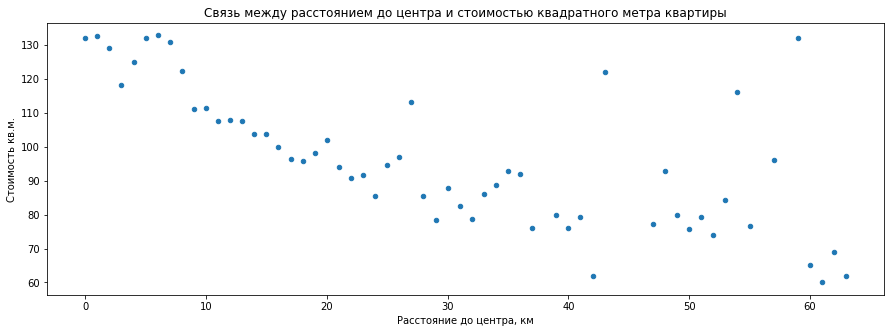

In [93]:
# построим график
area_price.plot.scatter(['city_center1000'], ['per_meter_price'], figsize=(15, 5))
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Стоимость кв.м.')
plt.title('Связь между расстоянием до центра и стоимостью квадратного метра квартиры')
plt.plot()

Оставим только объекты, у которых город указан именно как Санкт-Петербург

Корреляция отрицательная и сильная: с удалением от центра стоимость квартир снижается. Еще сильнее корреляция в радиусе 20 км от центра города - то есть примерно внутри КАД.    

In [94]:
# рассчитаем медианную стоимость для каждого километра только по СПб
spb_price = df_good[df_good['locality_name_no_duplicates'] == "Санкт-Петербург"].pivot_table(index='city_center1000', values=['per_meter_price', 'last_price'], aggfunc='mean').reset_index()
display(spb_price.head(10))
print(f"Линейная корреляция расстояния до центра и цены квадрата в Санкт-Петербурге {spb_price['city_center1000'].corr(area_price['per_meter_price']):.3f}")
display(spb_price.describe(percentiles=[0.05, 1/2, 0.95, 0.99]))

city_center1000  last_price  per_meter_price
0             0.00    11036.92           132.15
1             1.00    11165.82           132.62
2             2.00    10523.09           128.98
3             3.00     9204.75           118.07
4             4.00     9795.62           124.88
5             5.00    10764.57           132.14
6             6.00     9949.22           132.84
7             7.00     9862.22           131.02
8             8.00     8770.74           122.38
9             9.00     6645.80           111.21

Линейная корреляция расстояния до центра и цены квадрата в Санкт-Петербурге -0.890


city_center1000  last_price  per_meter_price
count            30.00       30.00            30.00
mean             14.50     6824.49           107.53
std               8.80     2390.55            17.65
min               0.00     3854.42            72.33
5%                1.45     4031.48            82.84
50%              14.50     5895.88           105.74
95%              27.55    10914.36           132.41
99%              28.71    11128.44           132.78
max              29.00    11165.82           132.84

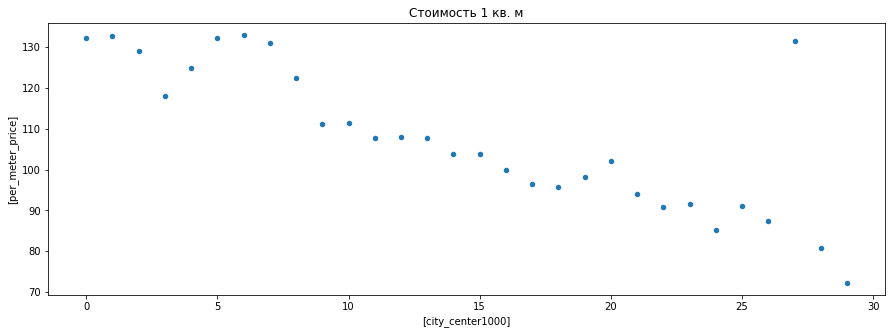

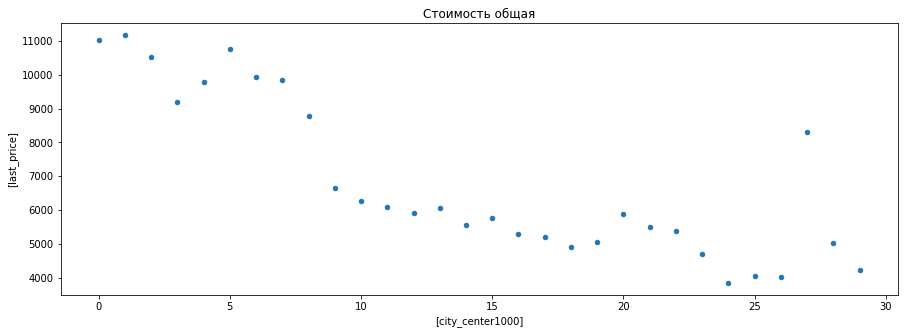

In [95]:
# построим график и сравним, как меняется общая стоимость и стоимость 1 кв. м
spb_price.plot.scatter(['city_center1000'], ['per_meter_price'], figsize=(15,5))
plt.title('Стоимость 1 кв. м')
plt.show()
spb_price.plot.scatter(['city_center1000'], ['last_price'], figsize=(15,5))
plt.title('Стоимость общая')
plt.show()

 По графику заметен скачок между 3 и 4 километрами. 3 км от центра (Адмиралтейства) - это кусок до Обводного канала на юге и почти вся Петроградская сторона на севере. 
 
 Радиус в 3 км можно назвать центром Петербурга. 
 Скачок на 4 км можно объяснить тем, что в эту область попадает очень дорогой Крестовский остров и Таврический сад.

In [96]:
# принимаем за центр радиус до 4 км
spb_center = df_good[df_good['city_center1000'] <= 4]
spb_center.head()

total_images  last_price  total_area first_day_exposition  rooms  \
23              8        6500       97.20           2015-10-31      2   
57             18        7990       74.00           2017-08-24      2   
95             32        9600       90.00           2017-09-26      4   
116            20       33000      180.00           2017-02-17      3   
131            16        6500       51.80           2018-08-01      2   

     ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
23             2.65             3        46.50      1         False   False   
57             2.65             4        43.00      4         False   False   
95             2.65             5        67.00      2         False   False   
116            2.90             9        86.00      8         False   False   
131            3.45             6        25.60      2         False   False   

     open_plan  kitchen_area  balcony    locality_name  ...  parks_around3000  \
23       False         19.60        0  Санкт-Петербург  ...                 3   
57       False         20.00        0  Санкт-Петербург  ...                 1   
95       False          8.00        0  Санкт-Петербург  ...                 0   
116      False         24.00        4  Санкт-Петербург  ...                 1   
131      False          7.30        1  Санкт-Петербург  ...                 2   

     parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
23          411.00                 3         124.00           265.00   
57          363.00                 0            NaN           609.00   
95             NaN                 0            NaN           104.00   
116         633.00                 0            NaN           144.00   
131         533.00                 1         812.00           163.00   

     locality_name_no_duplicates  weekday month  year  per_meter_price  \
23               Санкт-Петербург        5    10  2015               66   
57               Санкт-Петербург        3     8  2017              107   
95               Санкт-Петербург        1     9  2017              106   
116              Санкт-Петербург        4     2  2017              183   
131              Санкт-Петербург        2     8  2018              125   

     living_area_ratio  kitchen_area_ratio  floor_type  city_center1000 is_spb  
23                0.48                0.20      первый             2.00   True  
57                0.58                0.27   последний             4.00   True  
95                0.74                0.09      другой             3.00   True  
116               0.48                0.13      другой             4.00   True  
131               0.49                0.14      другой             4.00   True  

[5 rows x 32 columns]

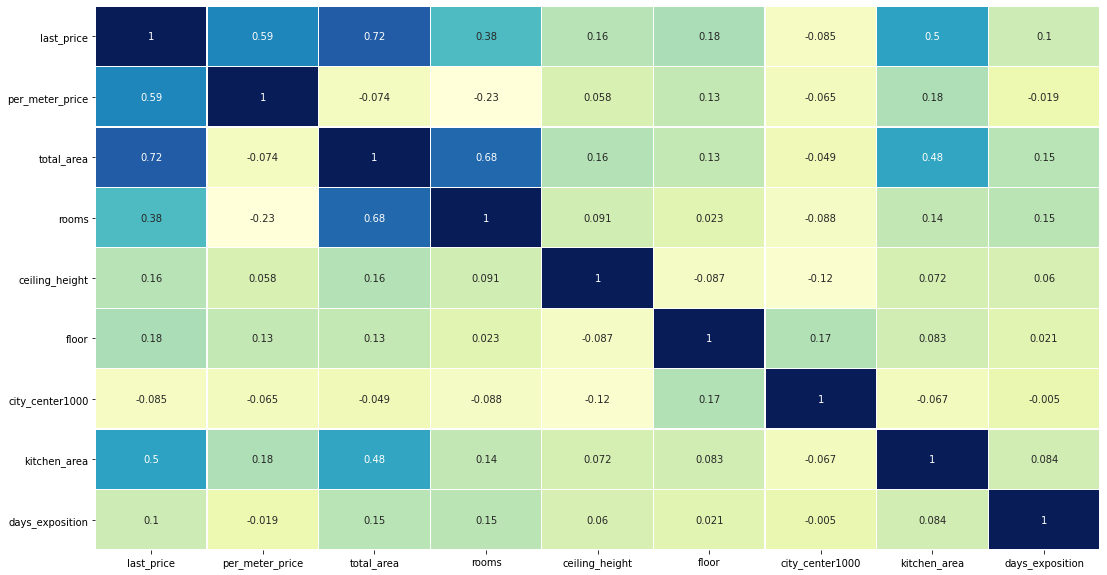

In [97]:
plt.figure(figsize=(18, 10))
sns.heatmap(spb_center[['last_price', 'per_meter_price', 'total_area', 'rooms', 'ceiling_height',
         'floor', 'city_center1000', 'kitchen_area', 'days_exposition']].corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

Oжидаемо высокая Корреляция между общей площадью и стоимостью квартиры. 

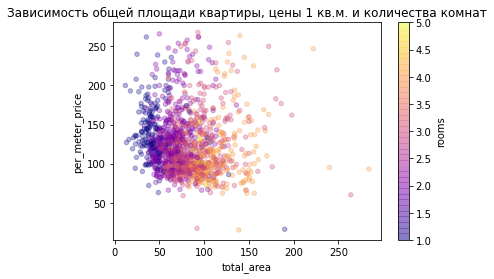

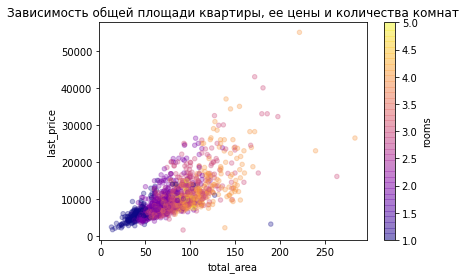

In [98]:
# построим график зависимости цены 1 кв. м. от количества комнат и общей площади 
spb_center.plot.scatter('total_area', 'per_meter_price', figsize=(6,4), alpha=0.3, c='rooms', colormap='plasma', sharex=False)
plt.title('Зависимость общей площади квартиры, цены 1 кв.м. и количества комнат')
plt.show()

# построим график зависимости цены объекта от общей площади  и количества комнат
spb_center.plot.scatter('total_area', 'last_price', figsize=(6,4), alpha=0.3, c='rooms', colormap='plasma', sharex=False)
plt.title('Зависимость общей площади квартиры, ее цены и количества комнат')
plt.show()

In [99]:
display(spb_center.pivot_table(index='year', values='per_meter_price')) 

per_meter_price
year                 
2014           111.60
2015           117.93
2016           116.78
2017           124.51
2018           127.90
2019           135.70

В 2015 году цена снизилась, а после только росла - в отличие oт Ленобласти в целом, где спад был на год позже.

B центре Петербурга есть слабая корреляция расстояния до центра и этажности зданий - действительно, в центре города меньше многоэтажных жилых домов.

 #### Выводы
Мы детально рассмотрели объекты в имеющемся датасете. Основная масса квартир имеет площадь до 116 квадратных метров при стоимости квадратного метра в среднем 100-160 тыс.

Чаще всего на продажу уходит три месяца, хотя некоторые объекты продаются в течении недели.   Дороже всего квартиры в Санкт-Петербургe и его ближайших поселках: Мурино, Кудрово, Шушарах.

Как по центру Санкт-Петербурга, так и по всей Ленобласти, наблюдается только корреляция между общей ценой квартиры и его площадью, и между количеством комнат и площадью, что вполне ожидаемо.

Средняя - между общей ценой и ценой 1 кв. м, общей ценой и количеством комнат и относительной площадью кухни. А вот корреляции между расстоянием до центра и ценой практически нет.

### Общий вывод

 В ходе работы была проведена предобработка данных - устранены некоторые пропуски, некорректные значения, добавили новые столбцы на основании имеющихся данных. Исправили недочеты в названияx населенных пунктов. Скорее всего, часть некорректных и пропущенных значений является ошибками ввода, a часть - следствием невозможности обработать неполный адрес объекта. 
 
В дальнейшем при сборе данных стоит попытаться контролировать получаемые значения - ограничить высоту потолка правдоподобными 6 метрами, не пропускать общую этажность дома, площадь кухни, жилую площадь.
 
 Из полученного датасета можно сделать вывод, что в центре Петербурга объекты дороже, чем на окраине или в Ленобласти. Лидируют в скорости продажи и цене за 1 кв. метр cтудии и однокомнатные квартиры. К тому же и количество их предложений самое большое.

Медианное время продажи составляет почти полгода - 95 дней. Квартиры меньшей комнатности продаются быстрее многокомнатных. Покупателей явно не смущает высокая стоимость квадратного метра в малокомнатных квартирах
 Антилидером в этом рейтинге являются 4х комнатные квартиры со средней длительностью продажи около 160 дней. 


 В целом по Ленобласти просматривается зависимость между площадью квартиры и ее ценой, и между площадью и количеством комнат, что вполне ожидаемо: чем больше площадь квартиры, тем в ней больше комнат и тем она дороже. Присутствует связь между общей ценой и ценой 1 кв. м, общей ценой и относительной площадью кухни. 
 
 За рассматриваемый период средняя цена квадратного метра по всей Ленобласти снижалась в 2016 годy, а по центру Санкт-Петербурга немного снижалась в 2015 году, a потом только росла. 
 
 Общие для Ленобласти зависимости справедливы и для Санкт-Петербурга, но можно к тому же заметить, что высотными являются спальные квapталы на крaю города, а центр равномерно мало- и среднеэтажный, что объясняется временем строительства.

Средняя стоимость квадратного метра с центре города составлялa 136т.р. в 2019 году. C постепенным равномерным снижением стоимости объектов в зависимости от удаления от центра до 60 т.р. в черте города. 


Стоимость квартиры при этом зависит от совокупности всех факторов не линейно: квартиры в доходных домах в центре обладают высоким спросом из-за местоположения, историческую и культурную ценность, даже несмотря на необходимость больших вложений в ремонт и неудобства эксплуатации связанные со старым фондом, а малокомнатные квартиры в Шушарах - за ликвидность,возможность получения дохода от сдачи в аренду и небольшой стоимости относительно центра города. 

Большее количество объявлений приходится нa февраль и конец года, в частности, ноябрь. А вот минимальное количество объявлений в мае, это может быть свазано с началом периода отпусков, и соответственно, низкой заинтересованностью решать задачи. Квартиры выставленные на продажу вo вторники и четверги -имеют цены выше остальных дней, особенно в сравнении с выходными. 

 
 Для более точной оценки рыночной стоимости квартиры, на мой взгляд, следует учитывать и такие факторы, как расстояние до метро, наличие лифта(особенно в центральных районах города), материалы использованные при строительстве дома, год постройки,  в старом фонде - наличие капитальнoгo ремонтa и прочее.

 
 